In [1]:
import netCDF4
import xarray as xr
import numpy as np
import pandas as pd
import os, glob
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import timedelta
from scipy.stats import pearsonr
import cartopy.crs as ccrs
import seaborn as sns
from matplotlib.pyplot import figure

In [2]:
# from ipynb.fs.full.spatial_Stage4_data_and_chris_data2003 import hrap_from_latlon, projection

In [2]:
def projection(filelist):
    import cartopy.crs as ccrs
    crs = ccrs.NorthPolarStereo()
    crs_proj4 = crs.proj4_init
    fiopen = xr.open_mfdataset(filelist)
    fiopen = fiopen.rio.write_crs(crs_proj4 , inplace=True)
    fiopen['x']=fiopen.x
    fiopen['y']=fiopen.y
    fiopen=fiopen.set_index({'x':'x' ,'y':'y'})
    fiopen.attrs['pyproj_srs'] = crs_proj4
    return fiopen

In [3]:
os.chdir('/data/dhence/a/pborse2/inputdata/data.eol.ucar.edu/pub/download/extra/katz_data/stage4/daily_data')
fi = [f for f in glob.glob('*.nc')]
fi.sort()

In [4]:
fiopen = projection(fi)
champbuck = fiopen['tp'].sel(x=slice(734.5,737.5),y=slice(488,490.5)).mean(('x','y')) # Area spanned by bucket locations in further analysis

In [5]:
##Function for importing bucket data in cleaned way
def buckdata(year):
    bucket = pd.read_excel('/data/dhence/a/pborse2/inputdata/Mosquito data/bucket Locations.xlsx', sheet_name=str(year))
    if(year==2003):
        bucket=bucket.iloc[3:]
    bucket =  bucket.replace(regex='([a-zA-Z])', value=0).fillna(0)
    bucket = bucket.replace('-',value=0)
    bucket.set_index('DATE',inplace=True)
    try:
        bucket.index = pd.to_datetime(bucket.index)
    except:
        pass
    for i in bucket.columns:
        bucket[i] = bucket[i].astype(float)
    return bucket

In [6]:
rain = projection(fi)['tp'].sel(x=slice(734.5,737.5),y=slice(488,490.5)).mean(('x','y'))

In [7]:
# Monthwise analysis
def monthly(year, rainfile,start,end):#give rain as input
    bucket = buckdata(year)
    rain=rainfile
    may = pd.DataFrame(bucket[bucket.index.month==5].sum(axis=1),columns=['lar'])
    junjul = pd.DataFrame(bucket[bucket.index.month.isin(range(6,8))].sum(axis=1),columns=['lar'])
    augsep = pd.DataFrame(bucket[bucket.index.month.isin(range(8,10))].sum(axis=1),columns=['lar'])
    for i in range(start,end):
        delt = may.index-timedelta(i)
        delt1 = junjul.index-timedelta(i)
        delt2 = augsep.index - timedelta(i)
        junjul['lag-'+str(i)]=rain[rain.time.dt.date.isin(delt1.date)].values
        if(year==2003):
            try:
                augsep['lag-'+str(i)]= np.append(rain[rain.time.dt.date.isin(delt2.date)].values,0)
#                 may['lag-'+str(i)]= np.append(rain[rain.time.dt.date.isin(delt.date)].values,0)
            except ValueError:
                augsep['lag-'+str(i)]= rain[rain.time.dt.date.isin(delt2.date)].values
#                 print(np.append(rain[rain.time.dt.date.isin(delt2.date)].values,0))
        else:
            augsep['lag-'+str(i)]=rain[rain.time.dt.date.isin(delt2.date)].values
            may['lag-'+str(i)]=rain[rain.time.dt.date.isin(delt.date)].values
    for i in range(2,len(junjul.columns)-1):
        may['accum-'+str(i)] = may[may.columns[1:i+1]].sum(axis=1)
        junjul['accum-'+str(i)] = junjul[junjul.columns[1:i+1]].sum(axis=1)
        augsep['accum-'+str(i)] = augsep[augsep.columns[1:i+1]].sum(axis=1)
        
    fig, axs = plt.subplots(ncols=4, gridspec_kw=dict(width_ratios=[1,1,1,0.05]),figsize=(22,22))
    try:
        sns.heatmap(may.corr()[['lar']],annot=True,ax=axs[0],vmin=-0.5,cbar=False)
    except:
        pass
    sns.heatmap(junjul.corr(method='spearman')[['lar']],annot=True,ax=axs[1],vmin=-0.5,cbar=False)
    sns.heatmap(augsep.corr(method='spearman')[['lar']],annot=True,ax=axs[2],vmin=-0.5,cbar=False)
    axs[0].set_title('May-'+str(year),fontsize = 20)
    axs[1].set_title('Jun-Jul-'+str(year),fontsize = 20)
    axs[2].set_title('Aug-Sept-'+str(year),fontsize = 20)
    fig.colorbar(axs[1].collections[0], cax=axs[3])
    
    fig1, axs1 = plt.subplots(nrows=3, ncols=1,figsize=(20,20))
    try:
        may.corr()[['lar']].plot(ax=axs1[0])
        axs1[0].axhline(0)
    except:
        pass
    junjul.corr()[['lar']].plot(ax=axs1[1])
    axs1[1].axhline(0)
    augsep.corr()[['lar']].plot(ax=axs1[2])
    plt.axhline(0)
    return rain,junjul,augsep

/tmp/ipykernel_166738/2752373326.py:30: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(may.corr()[['lar']],annot=True,ax=axs[0],vmin=-0.5,cbar=False)
/tmp/ipykernel_166738/2752373326.py:42: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  may.corr()[['lar']].plot(ax=axs1[0])
/tmp/ipykernel_166738/2752373326.py:30: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(may.corr()[['lar']],annot=True,ax=axs[0],vmin=-0.5,cbar=False)
/tmp/ipykernel_166738/2752373326.py:

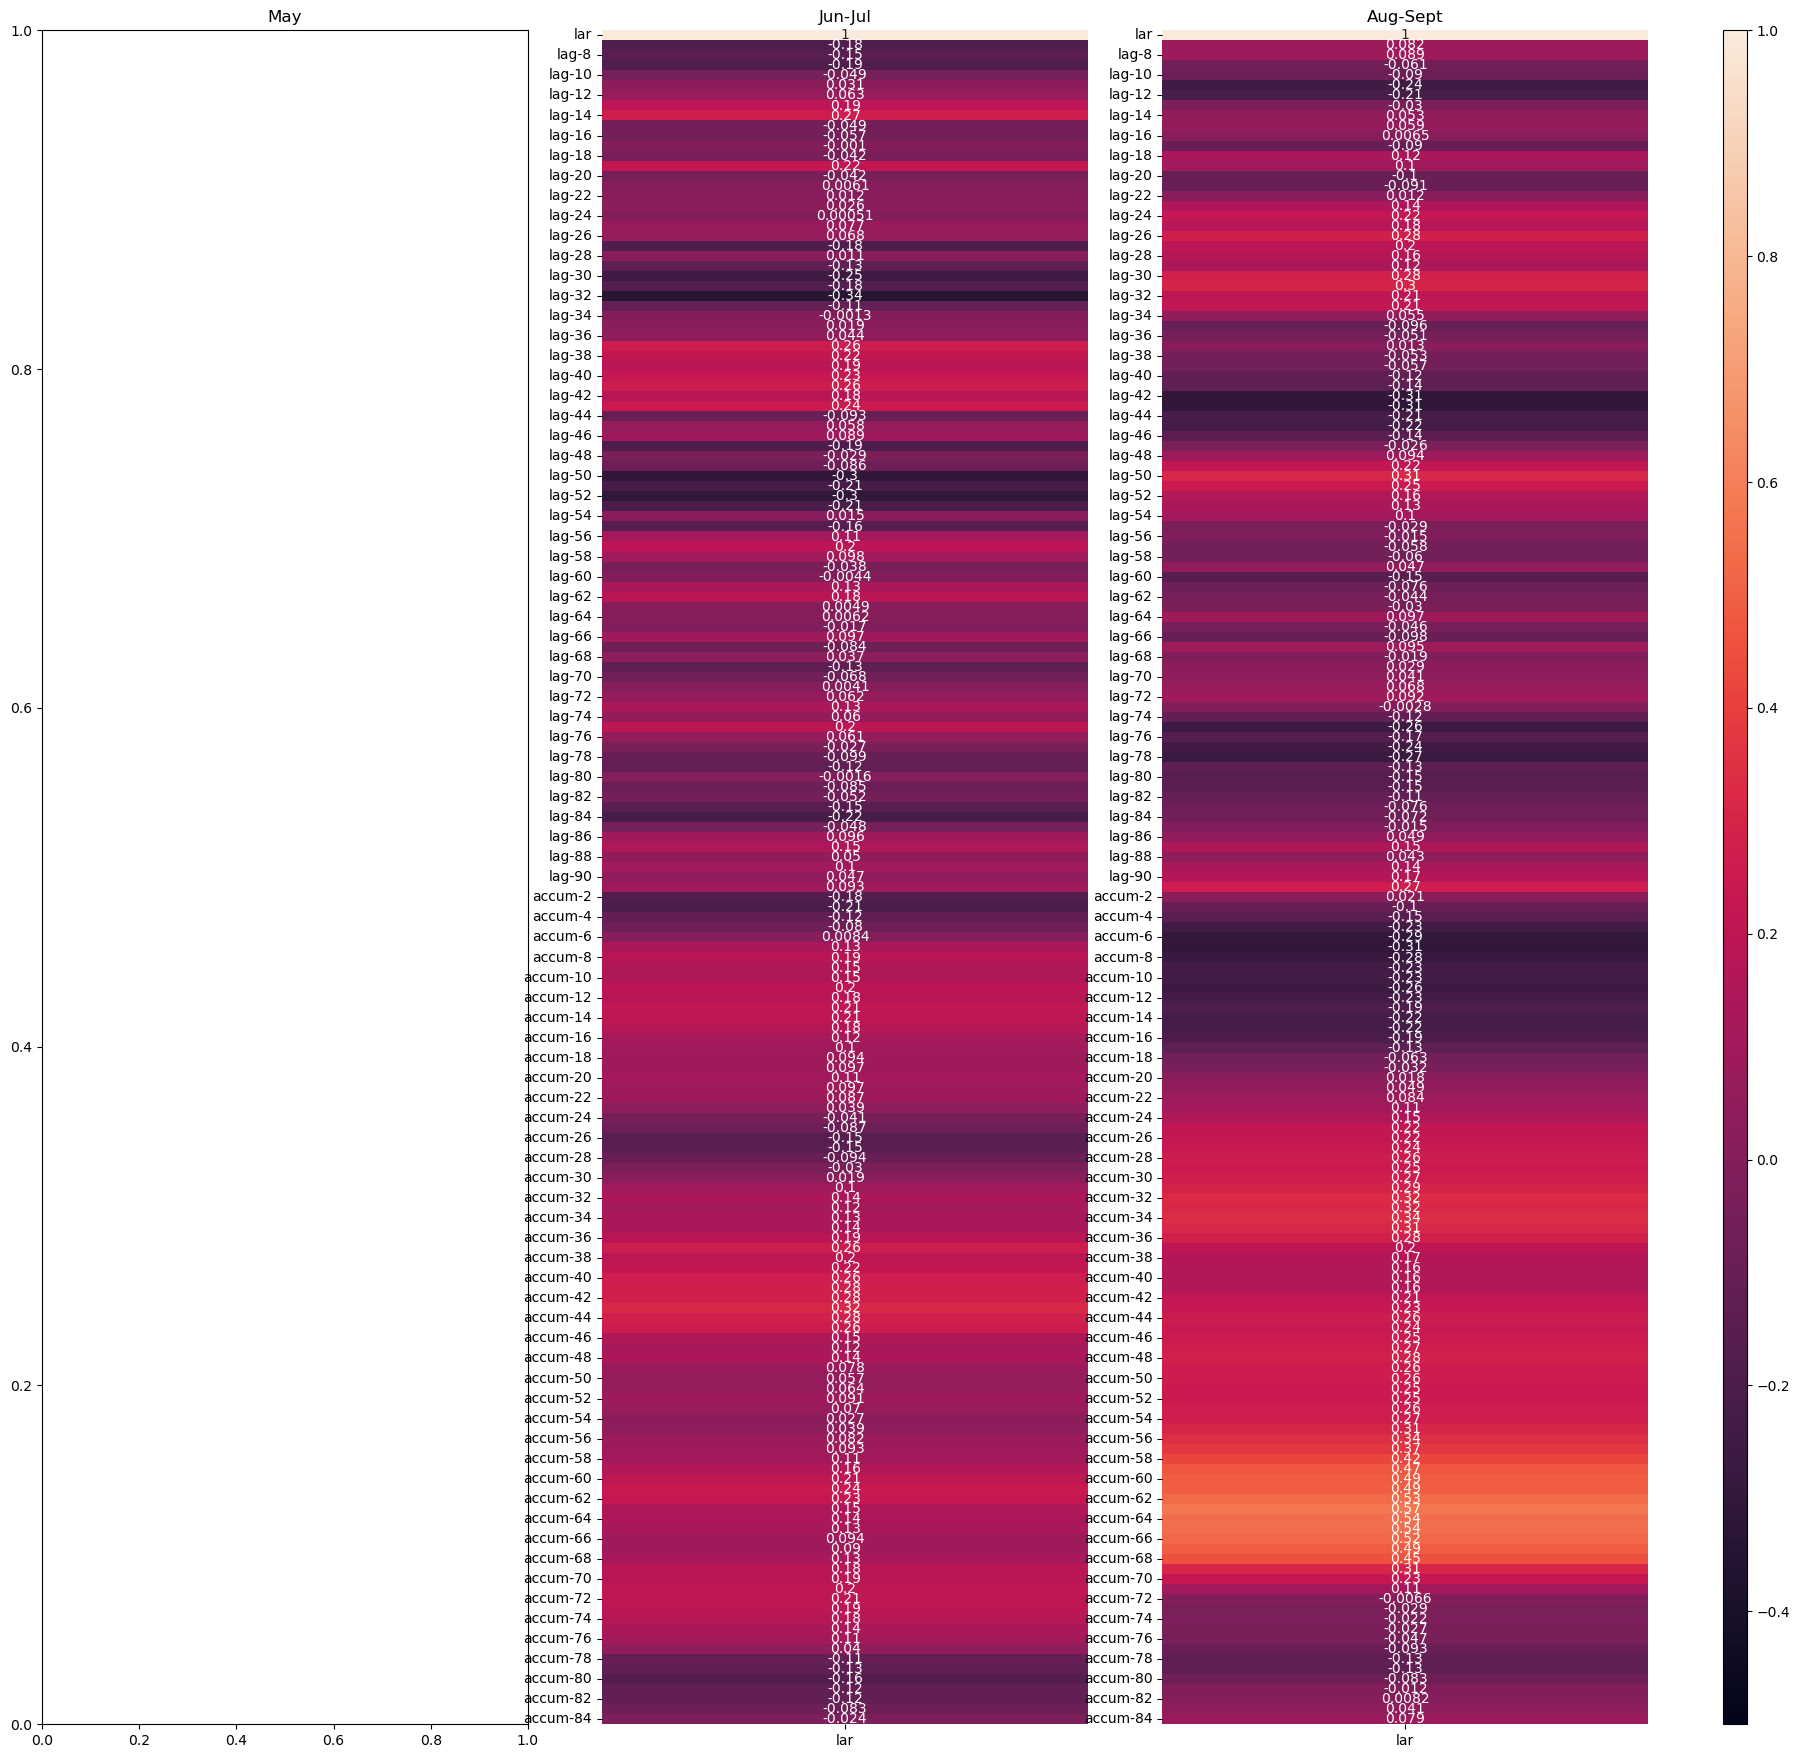

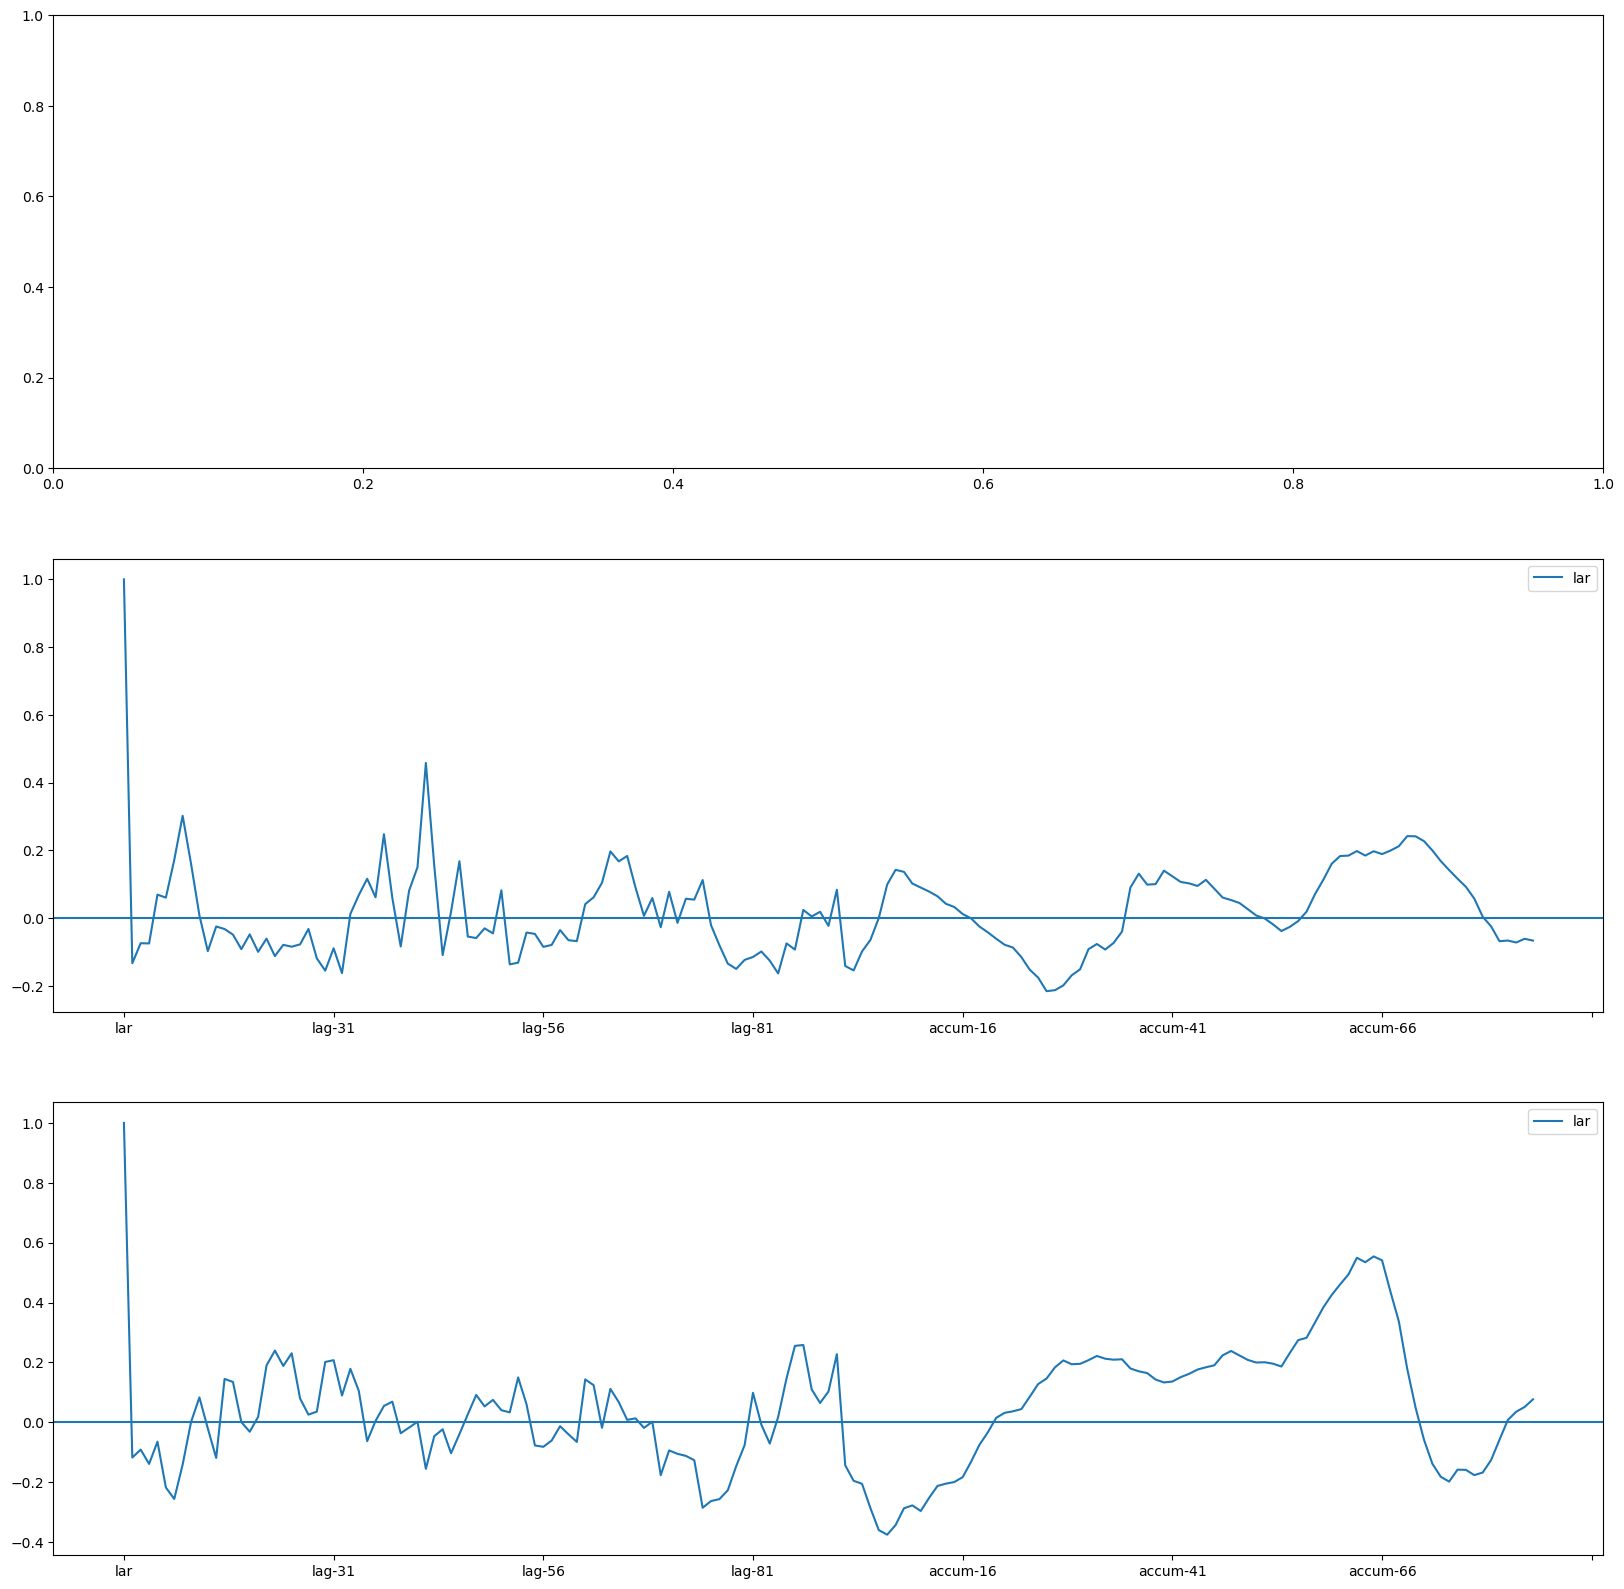

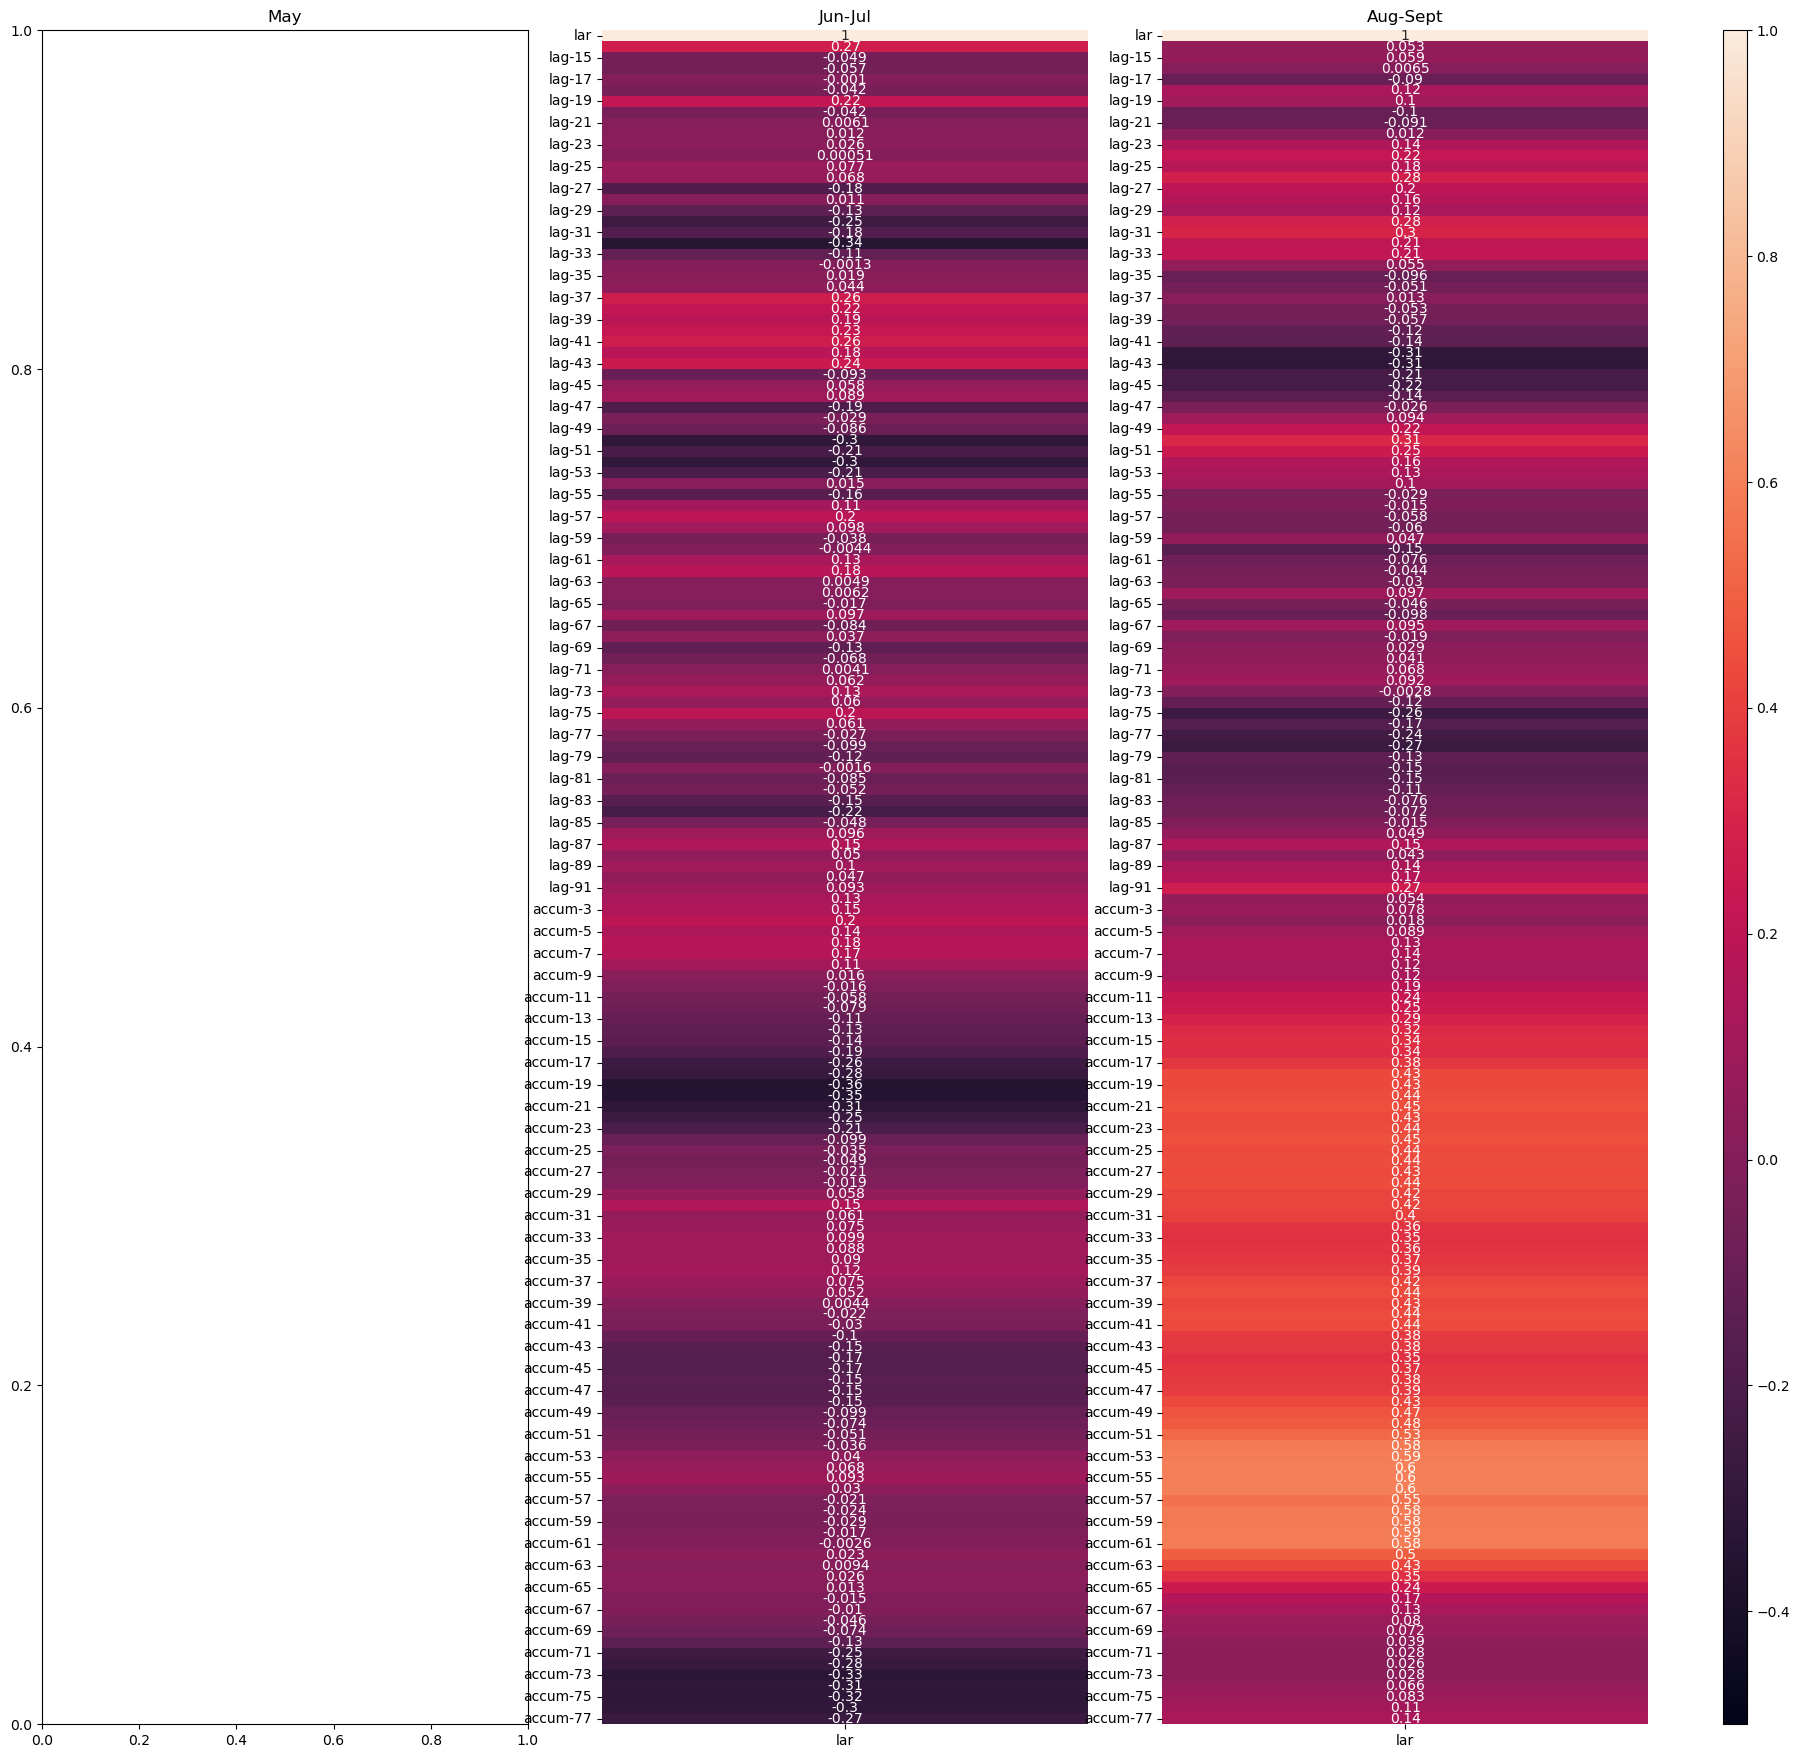

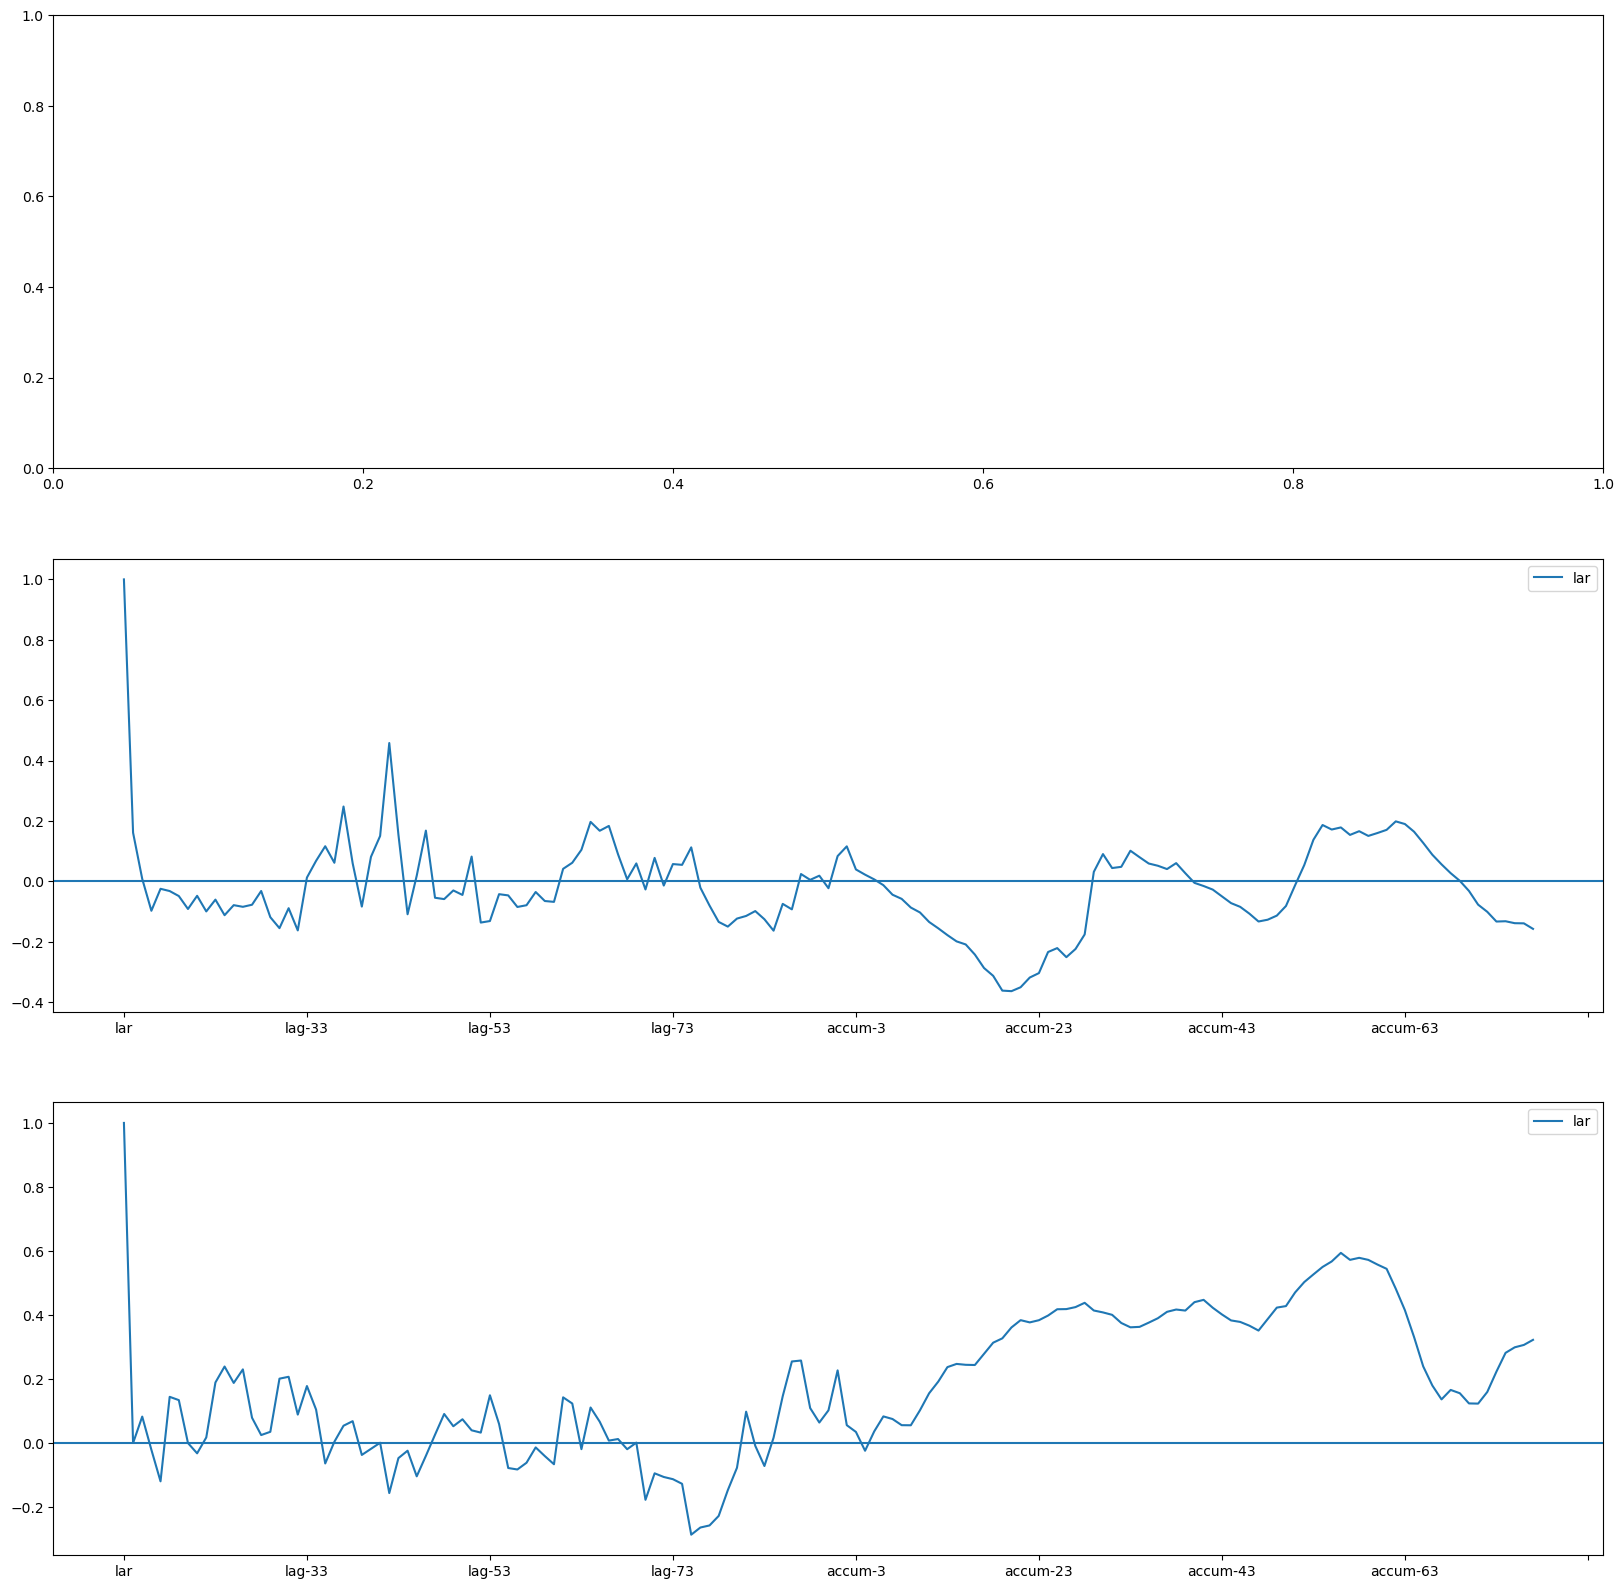

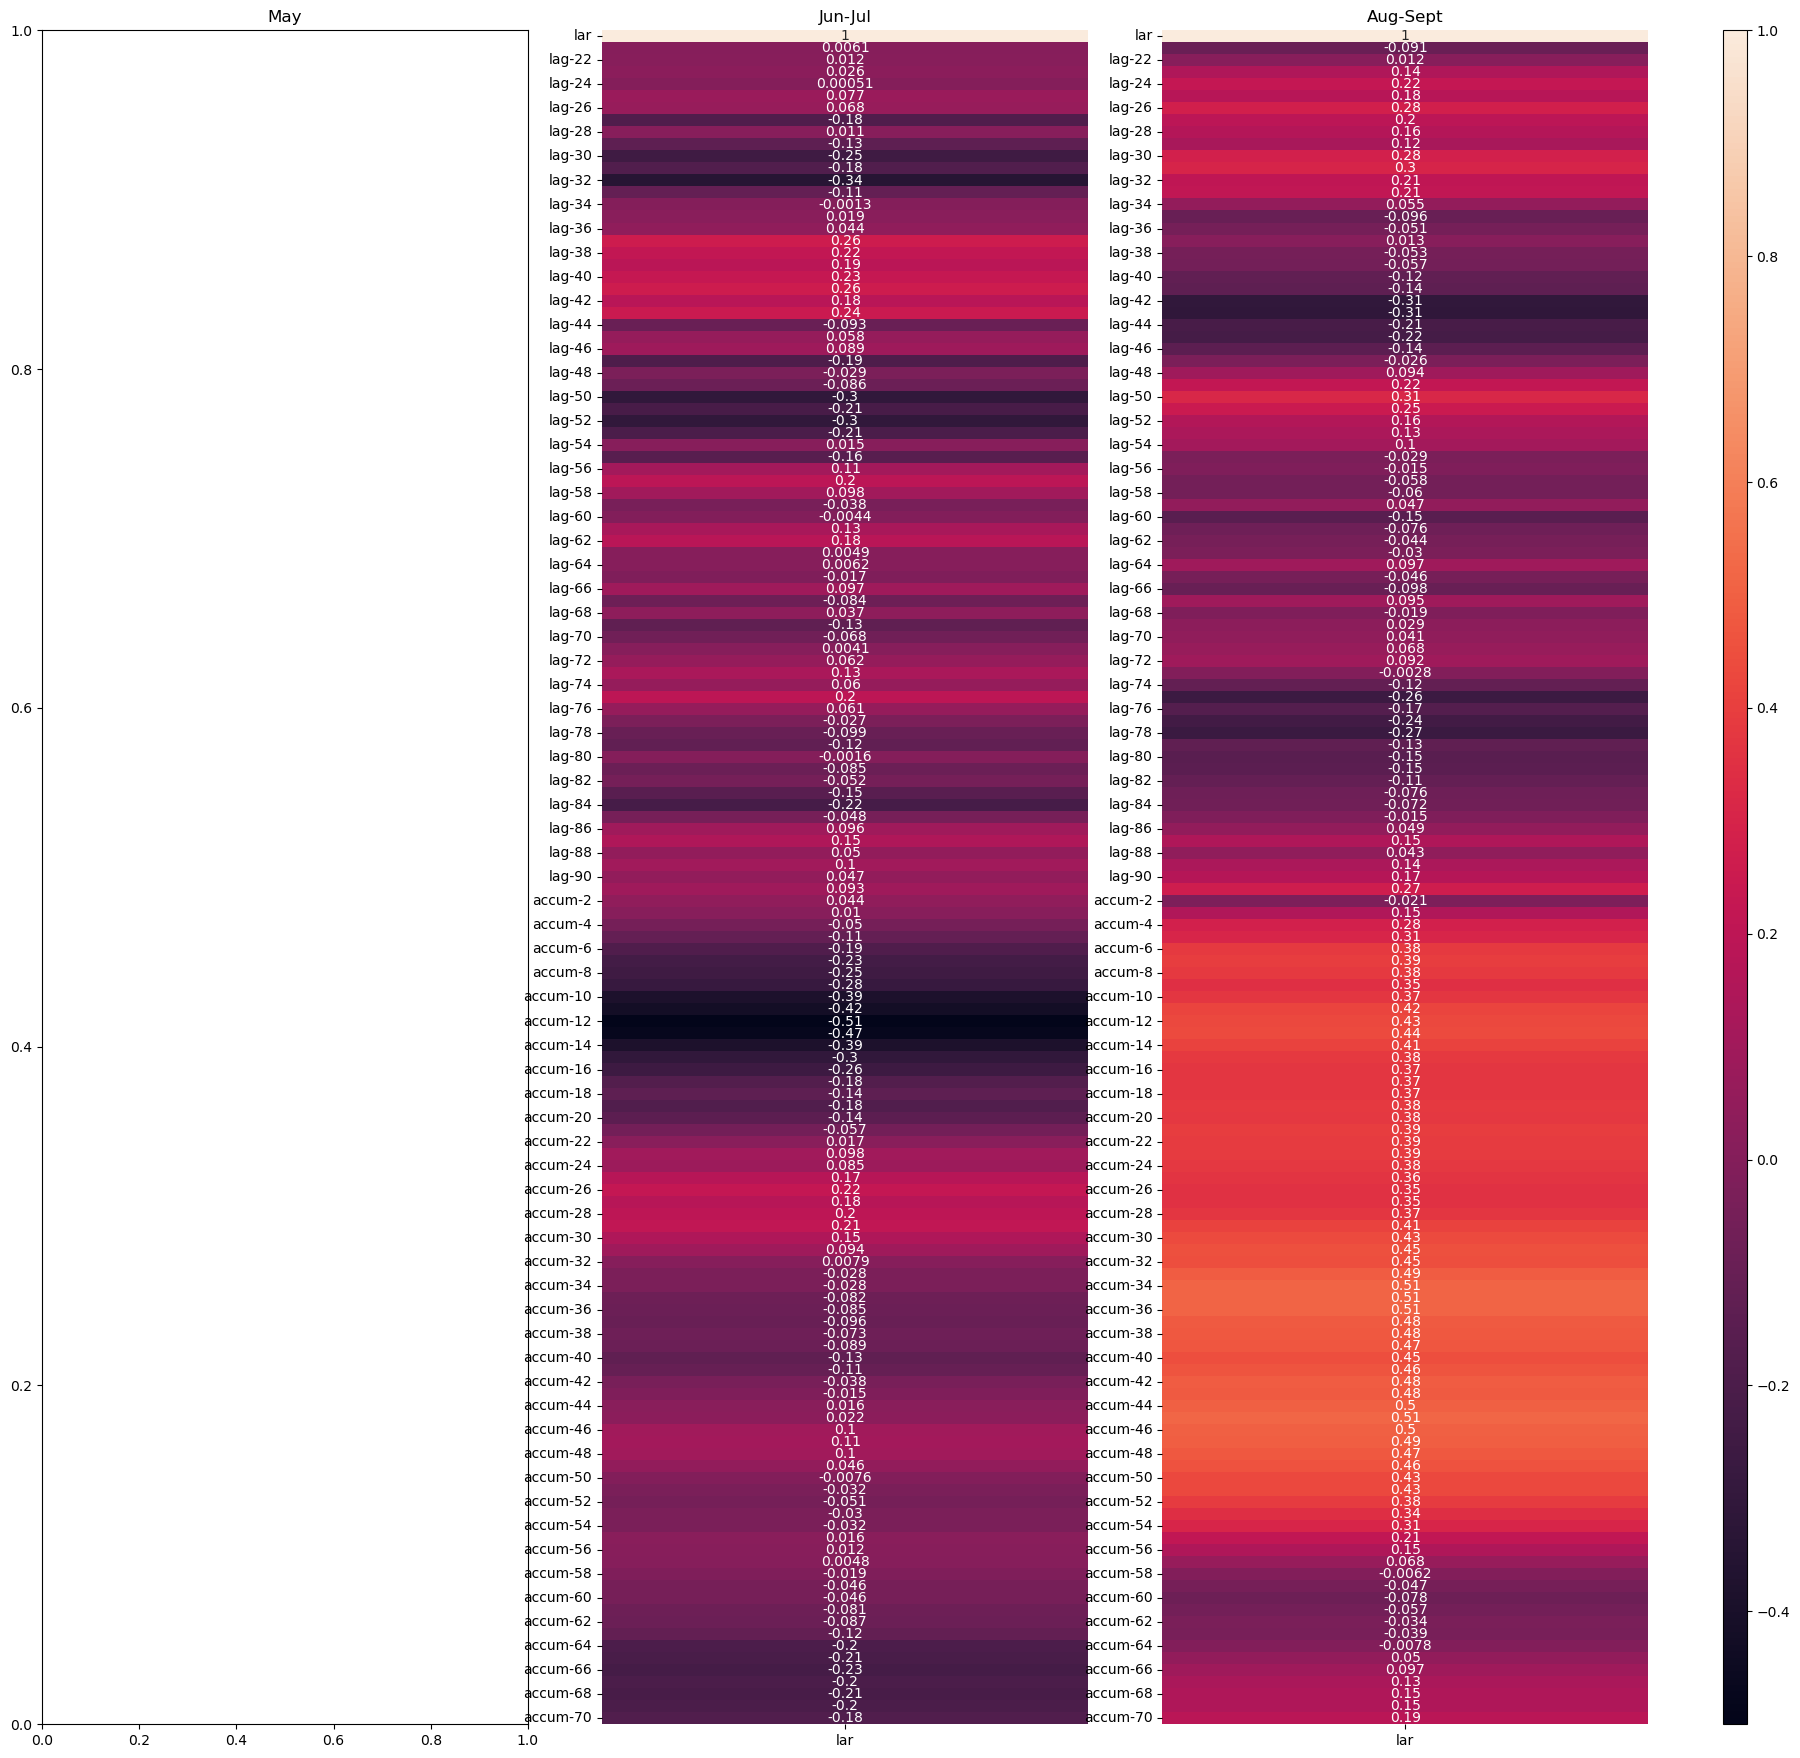

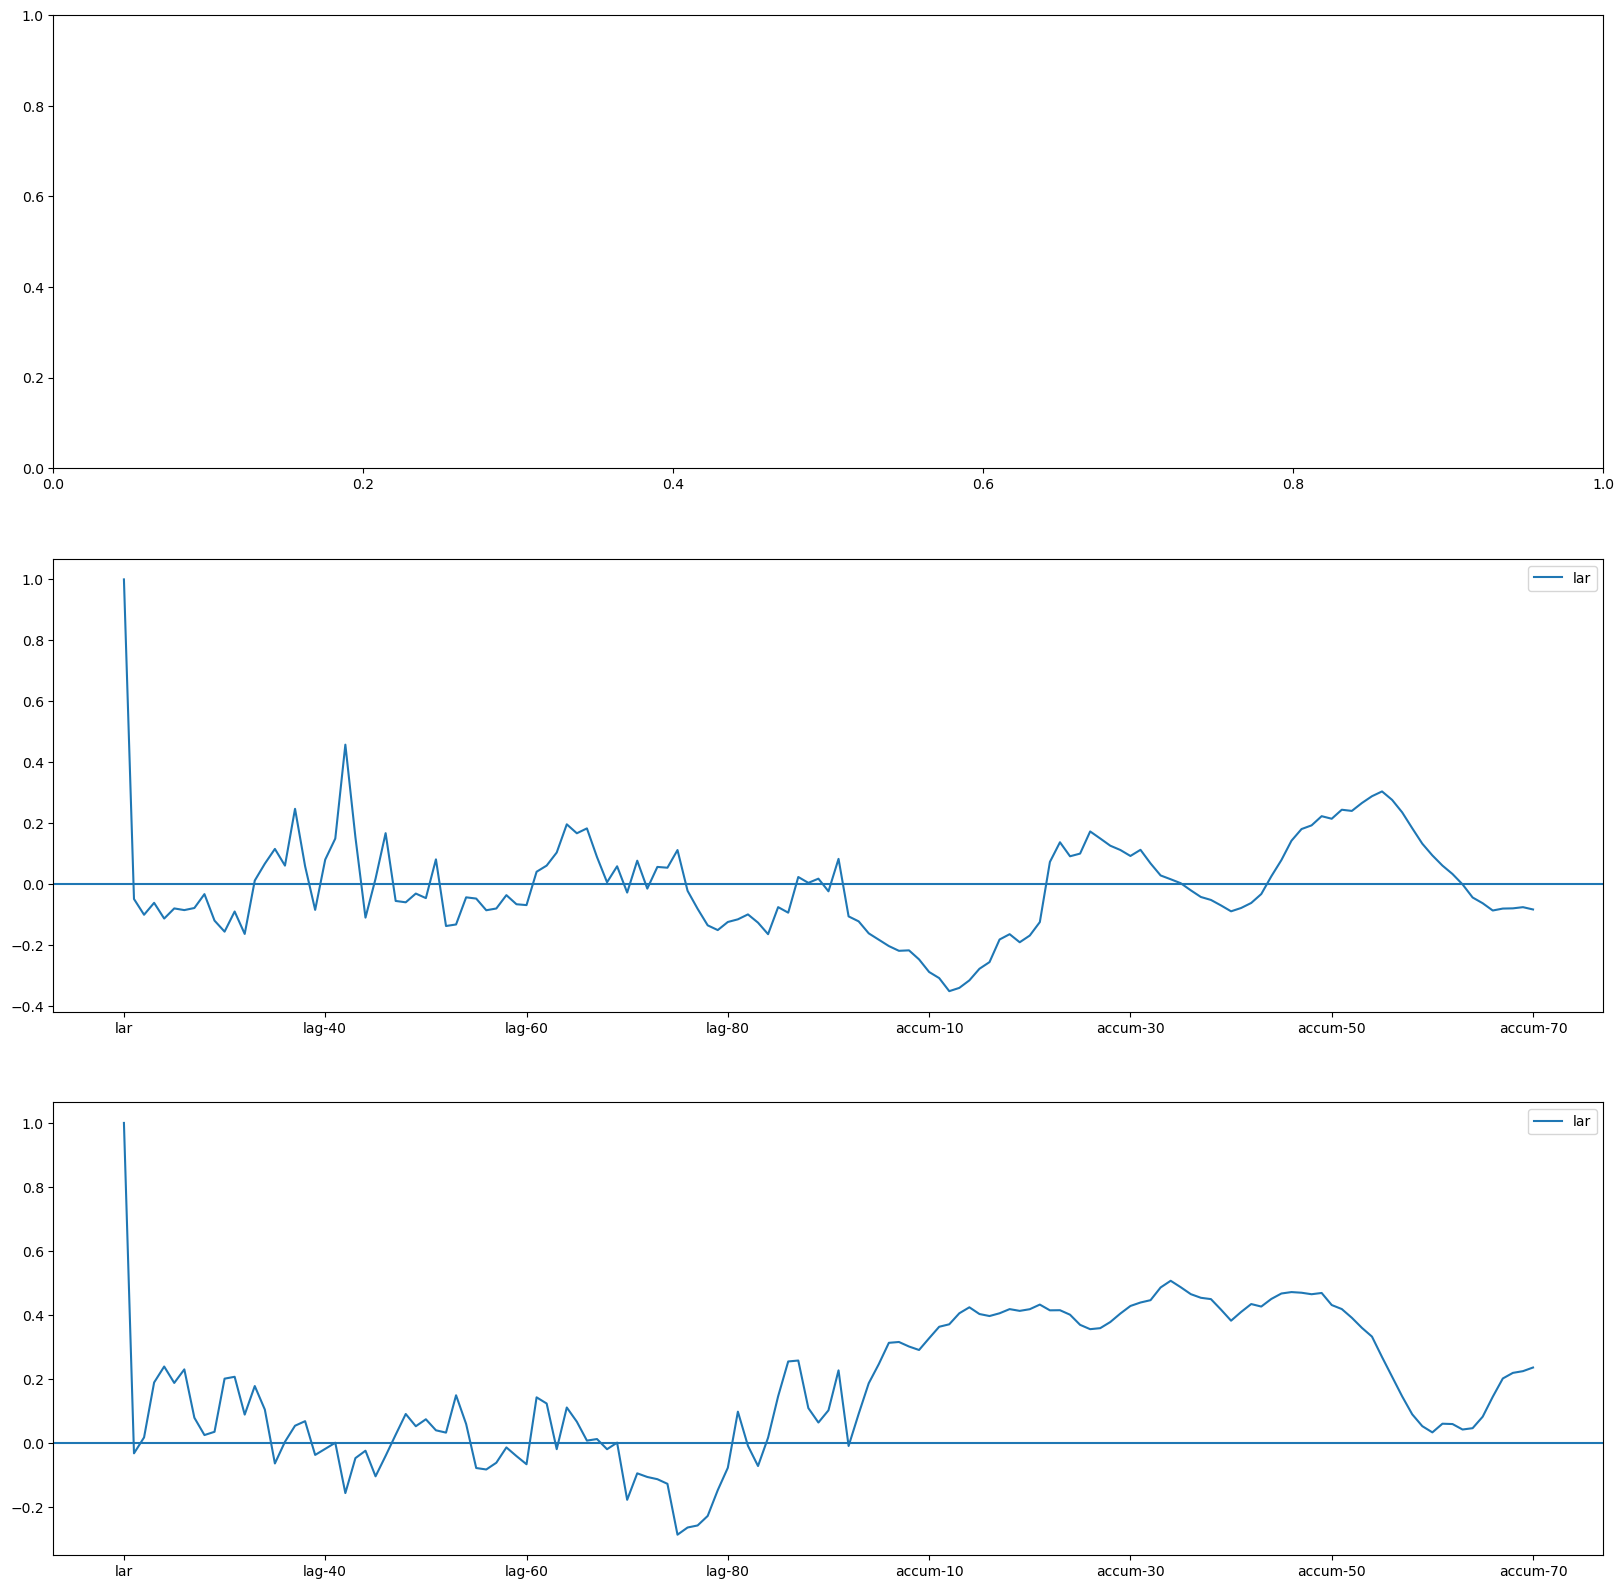

In [9]:
r1= monthly(2005,rain,7,92)
r2 = monthly(2005,rain,14,92)
r3 = monthly(2005,rain,21,92)

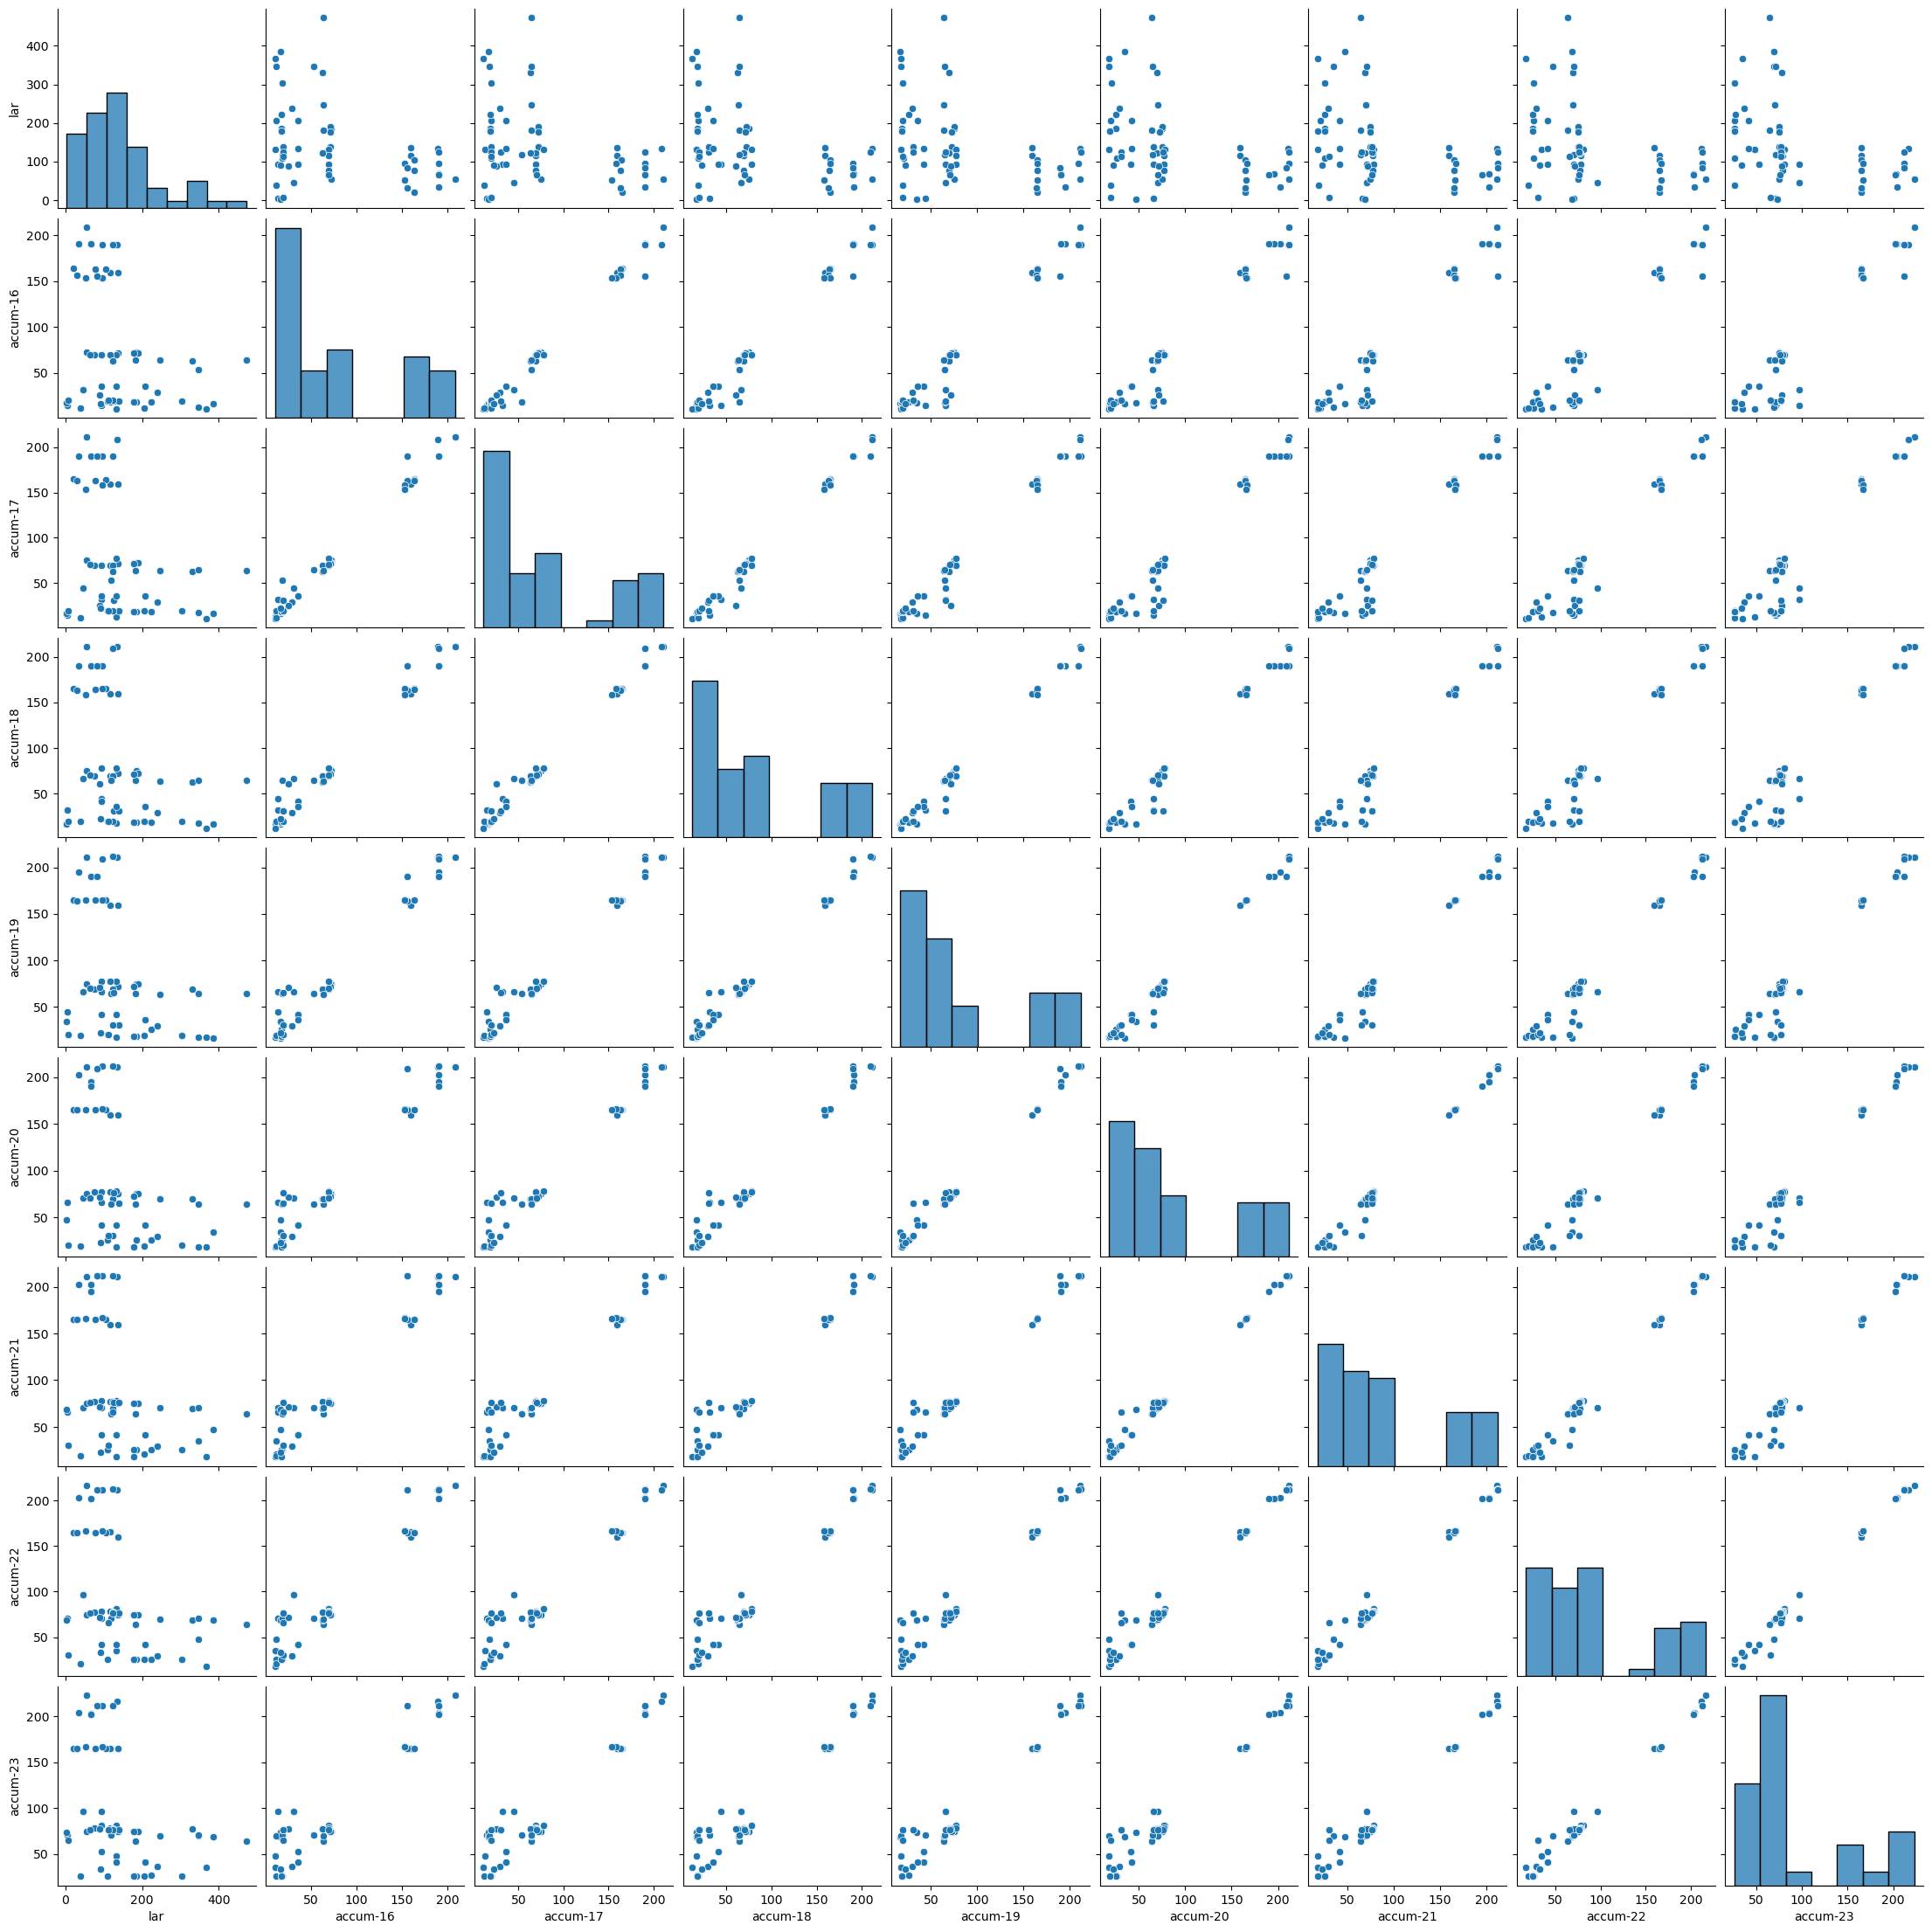

In [48]:
sns.pairplot(r1[1][['lar',*r1[1].columns[100:108]]])
# sns.relplot(data=r1[1],x=r1[1].index,y='accum-16')

/tmp/ipykernel_56752/4175142287.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax= plt.subplots(figsize=(6,5))


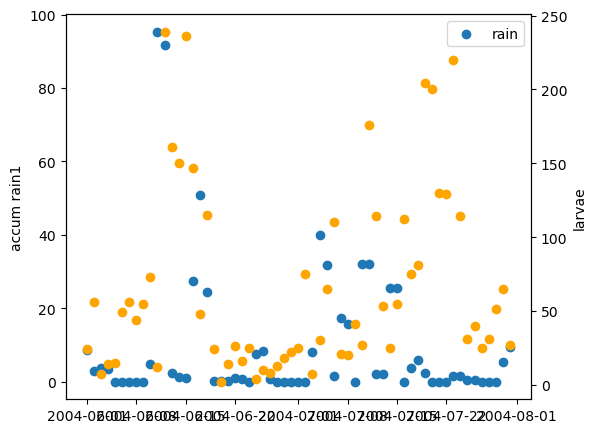

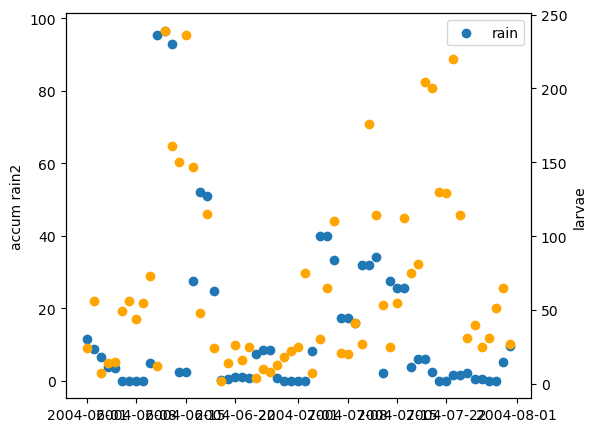

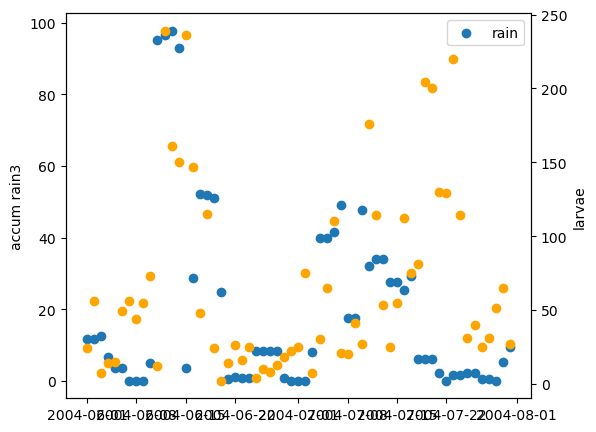

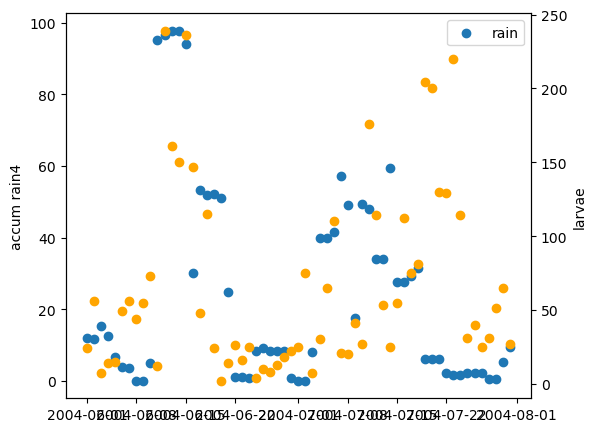

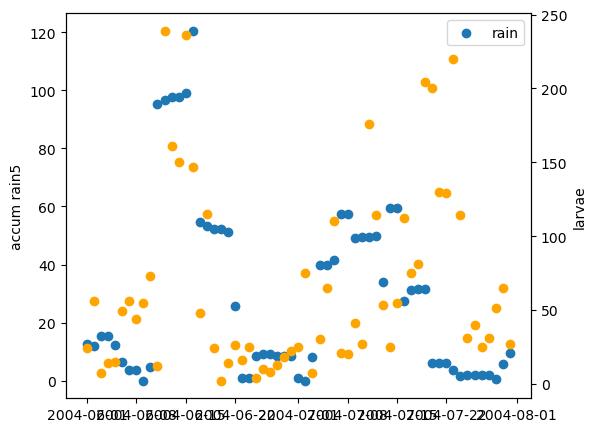

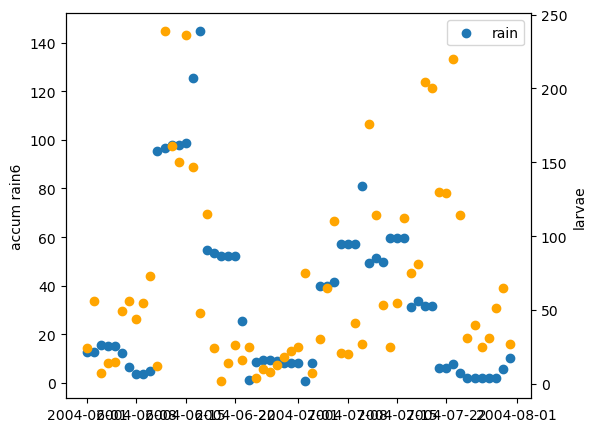

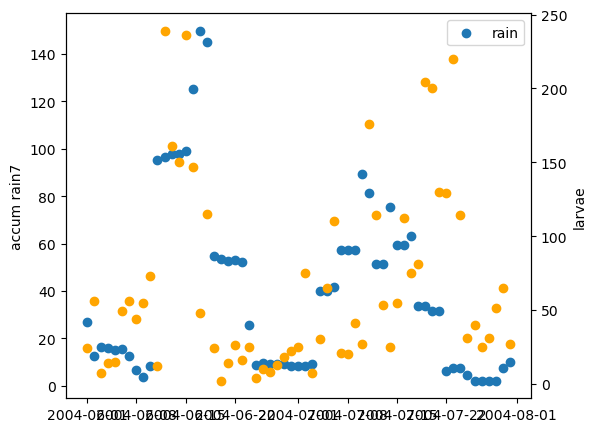

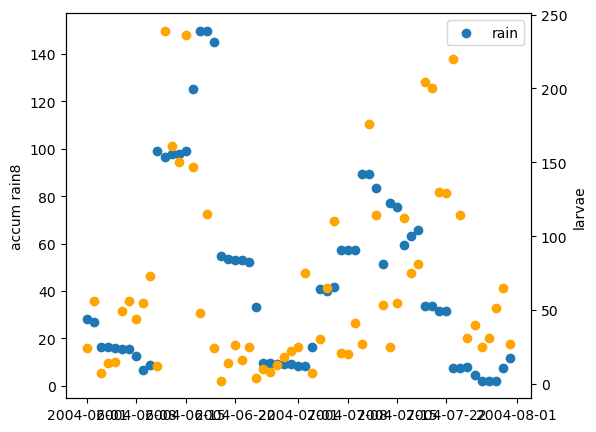

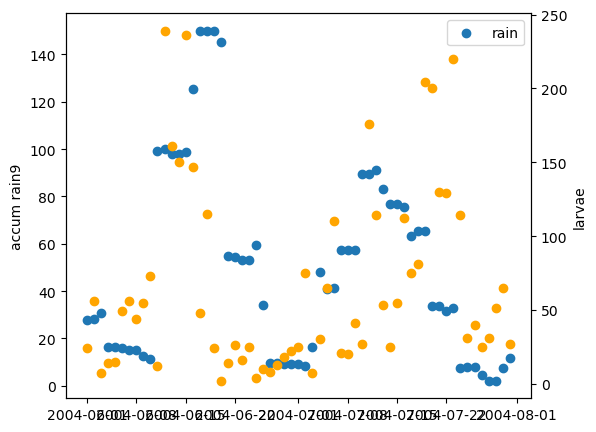

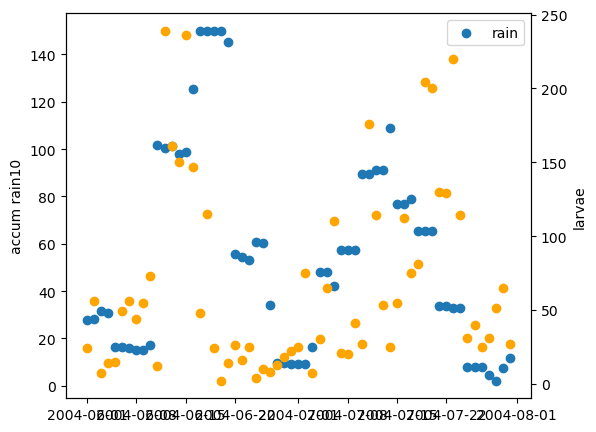

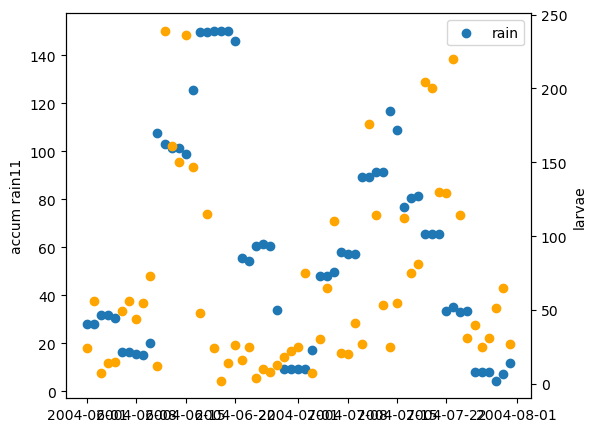

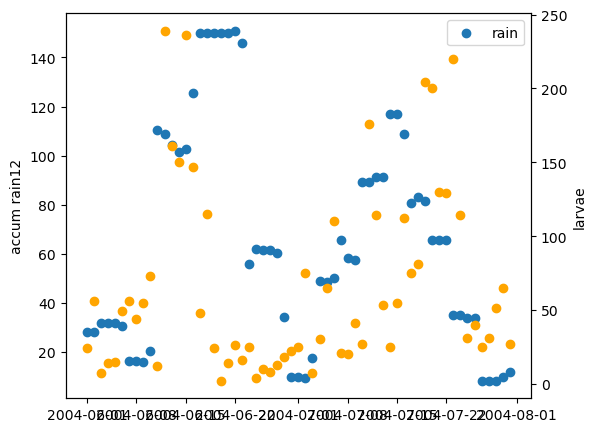

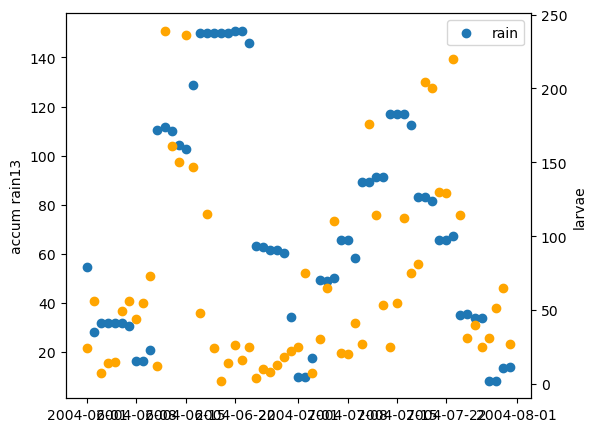

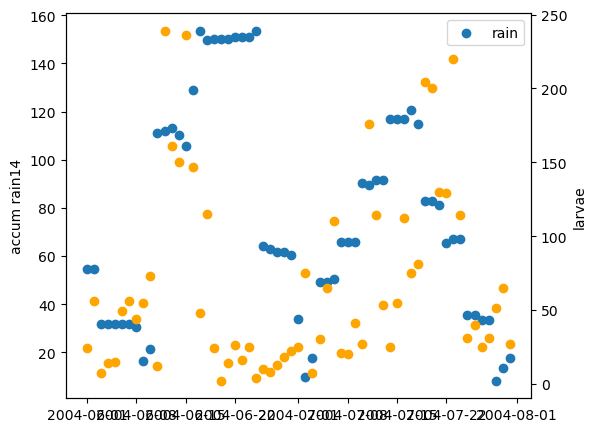

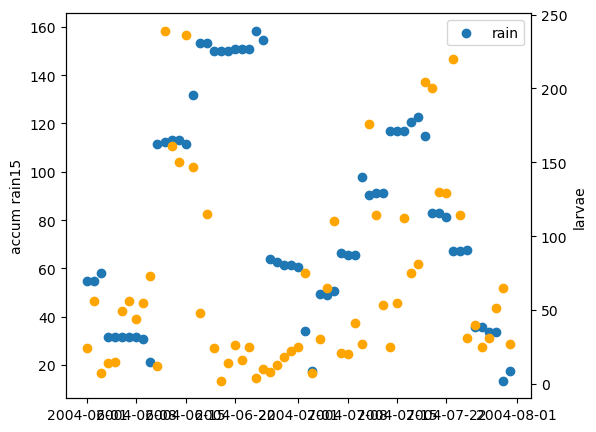

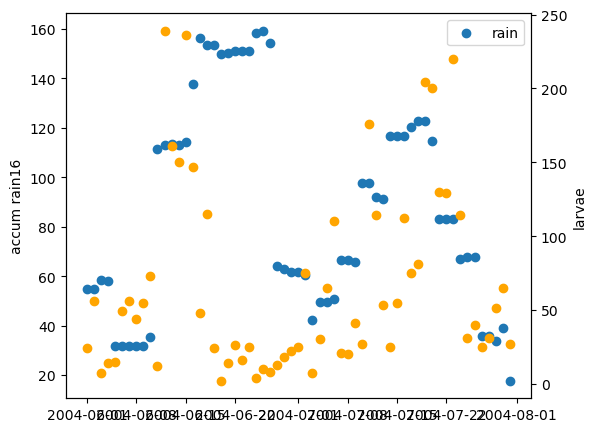

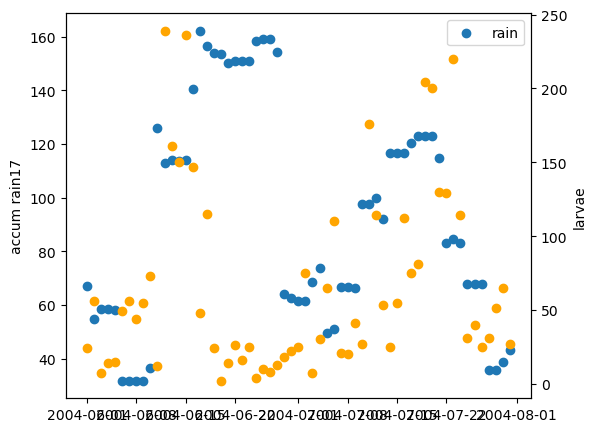

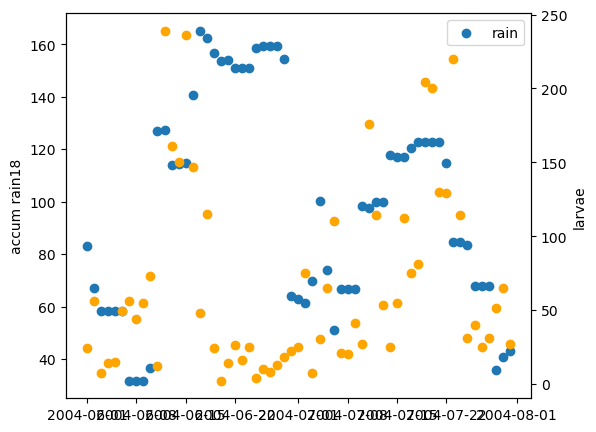

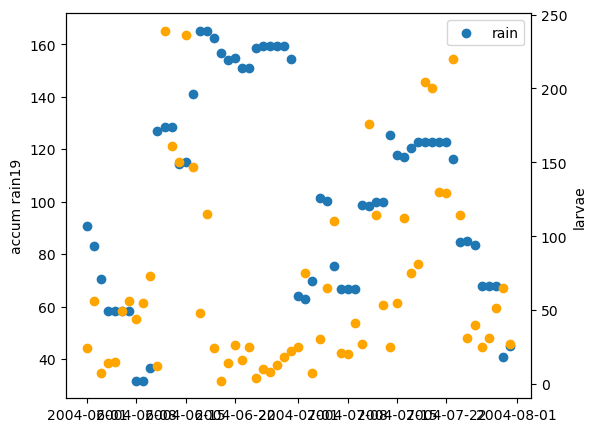

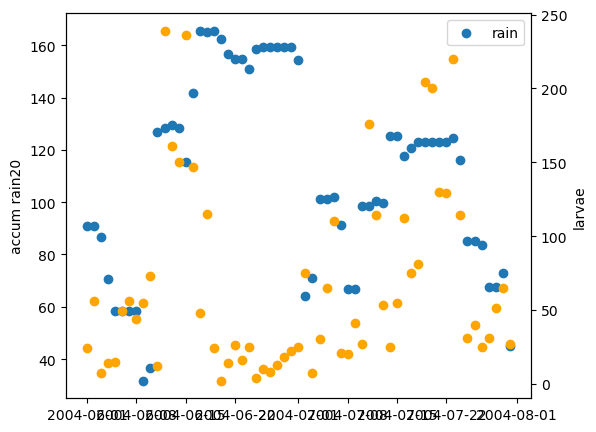

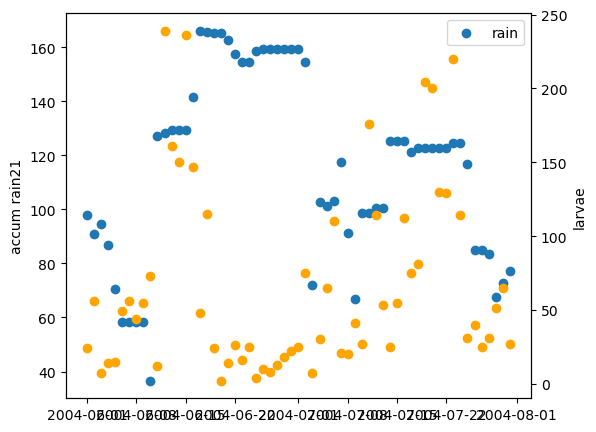

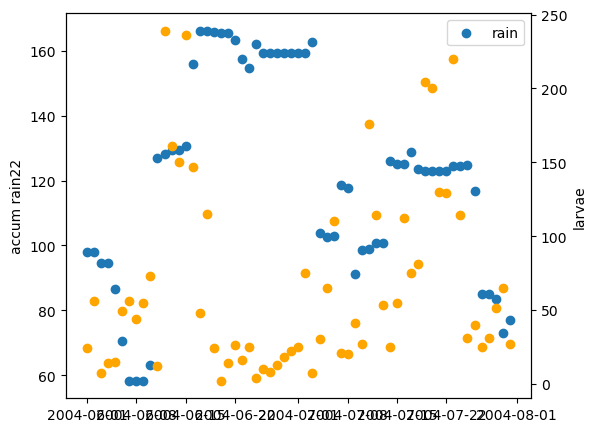

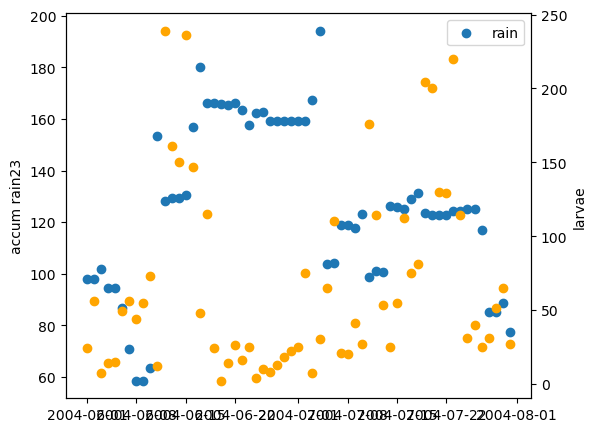

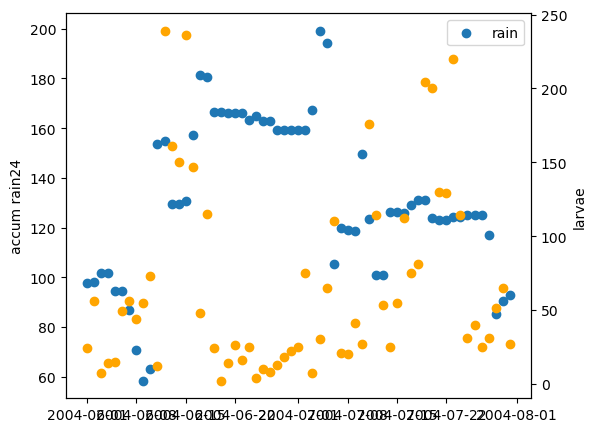

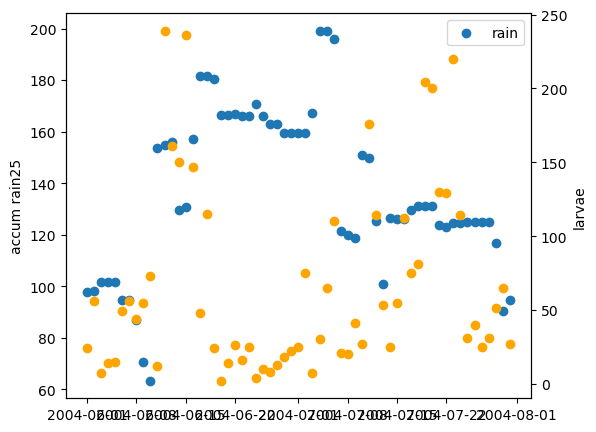

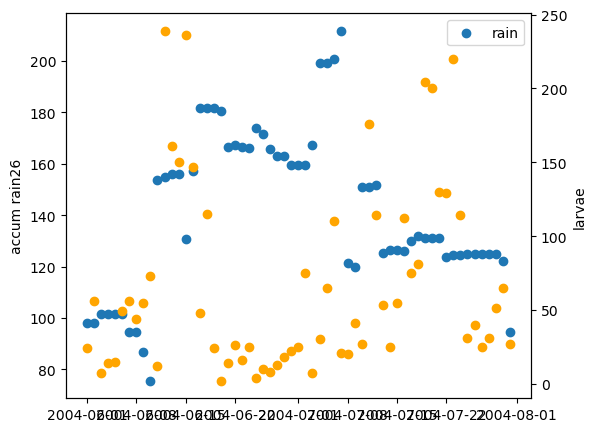

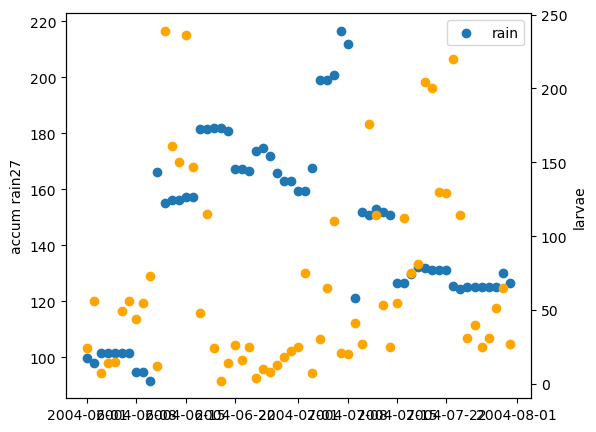

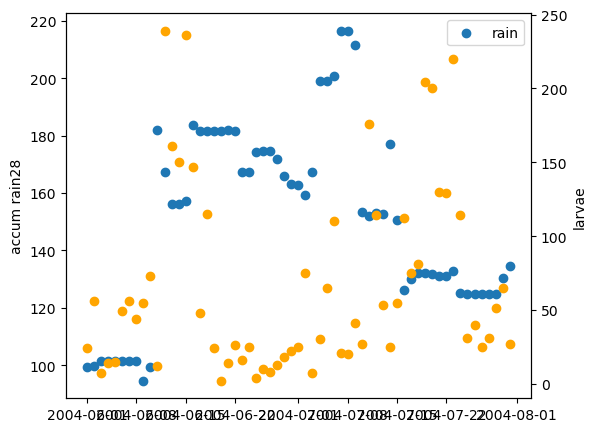

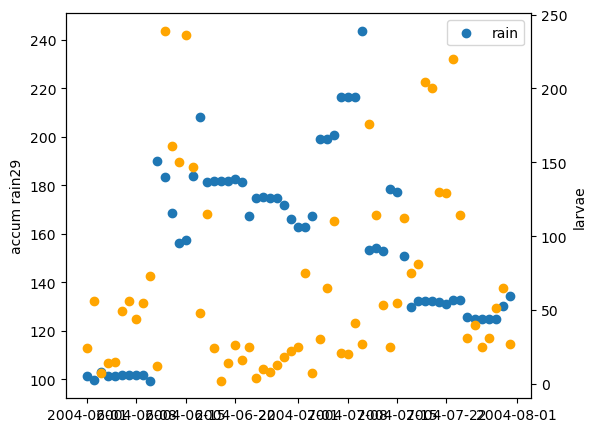

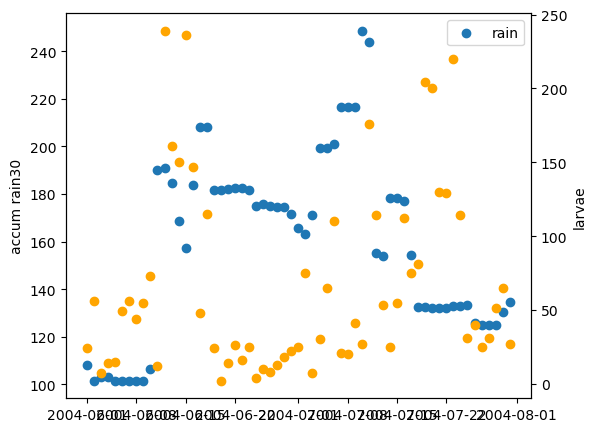

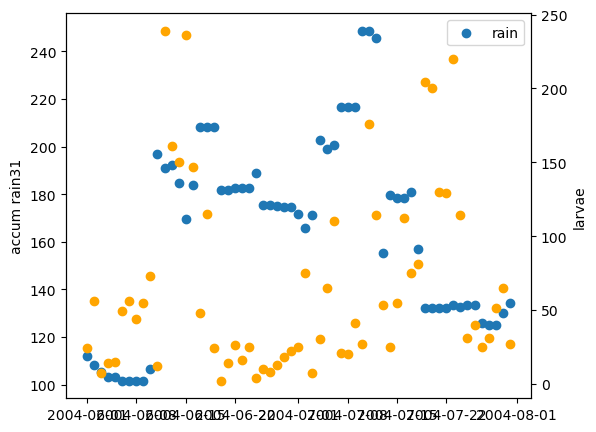

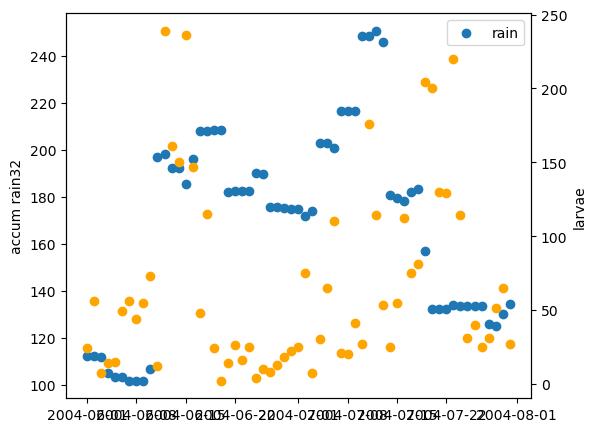

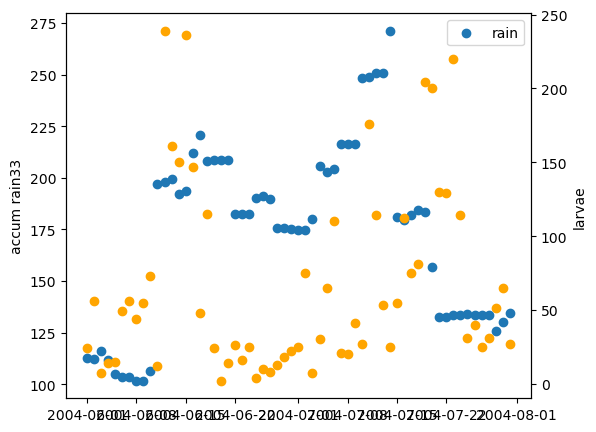

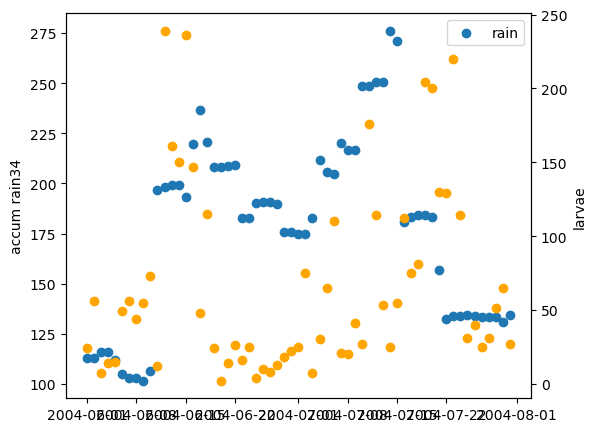

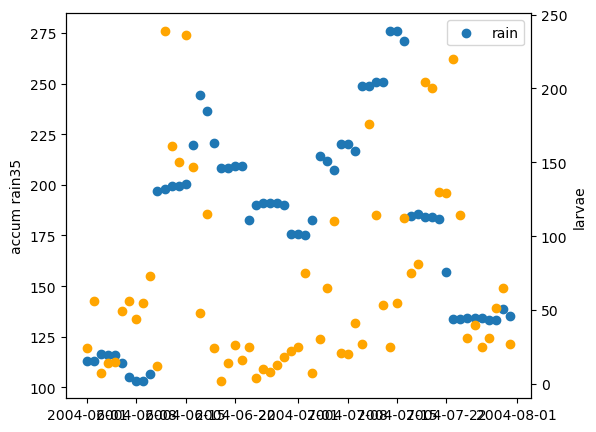

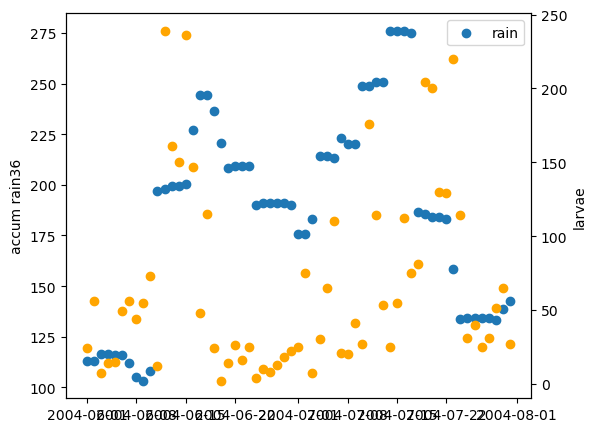

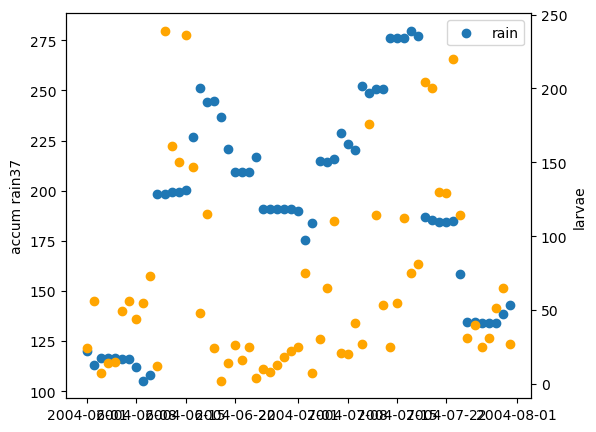

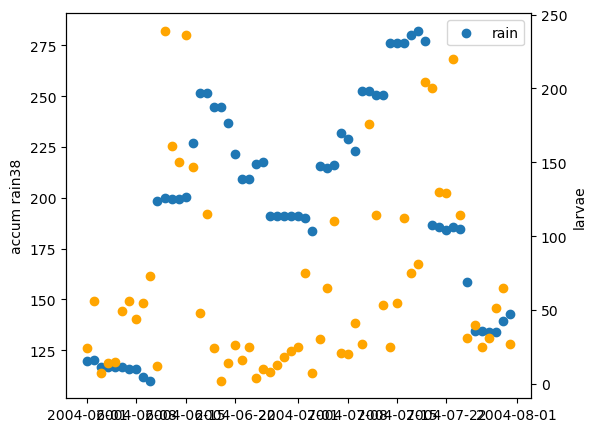

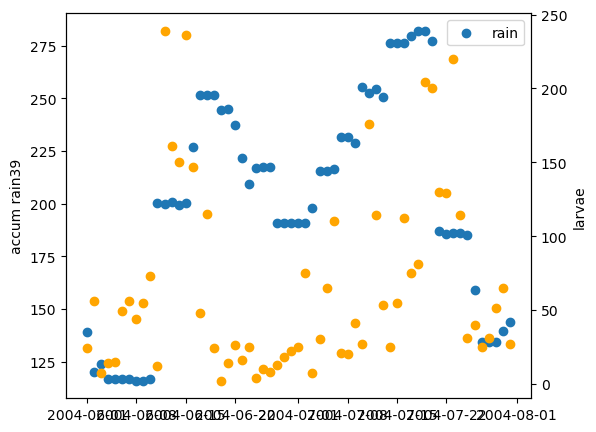

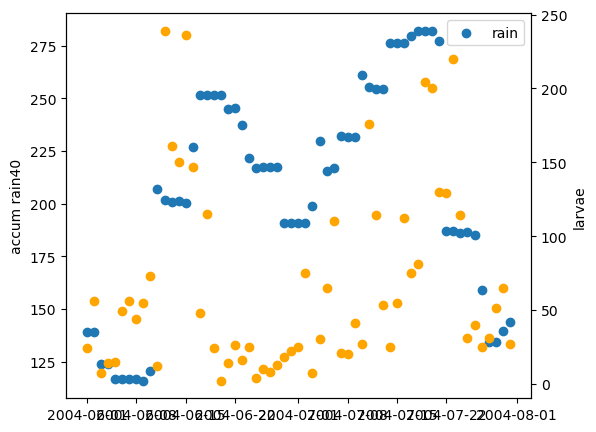

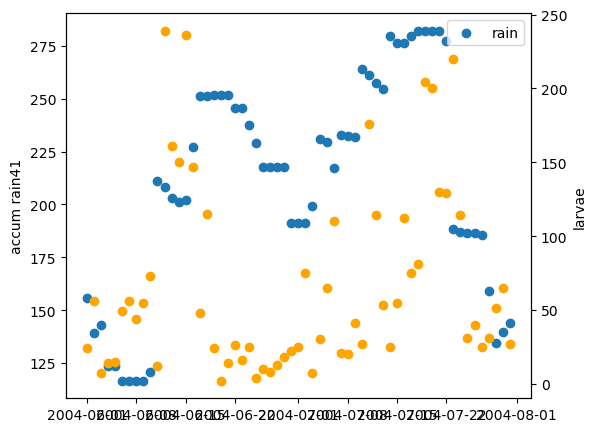

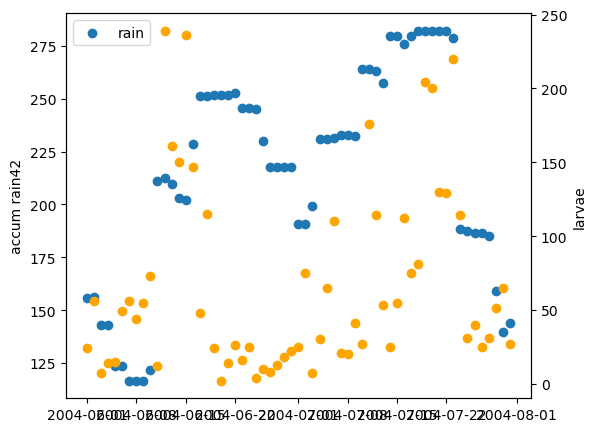

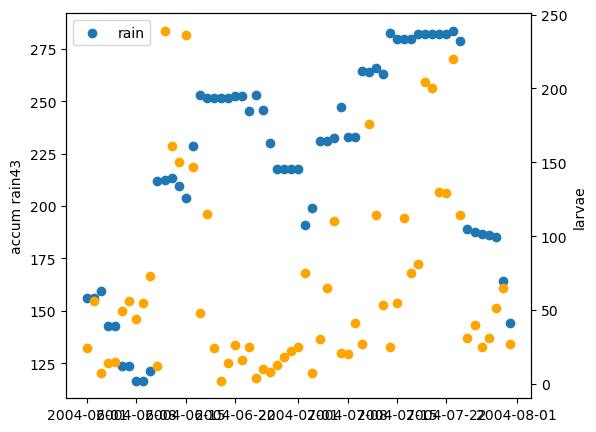

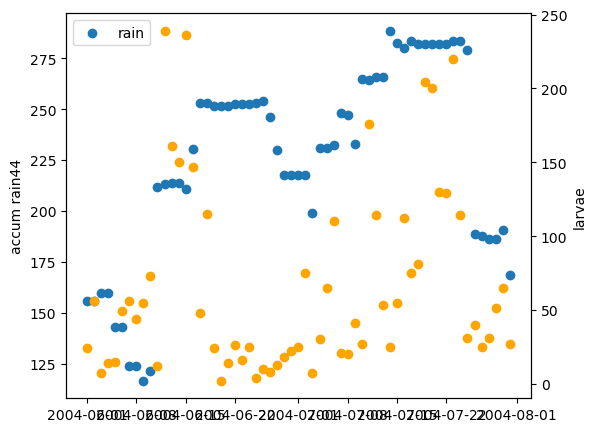

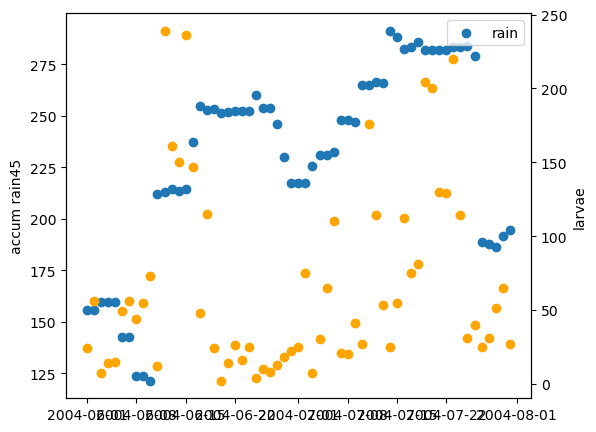

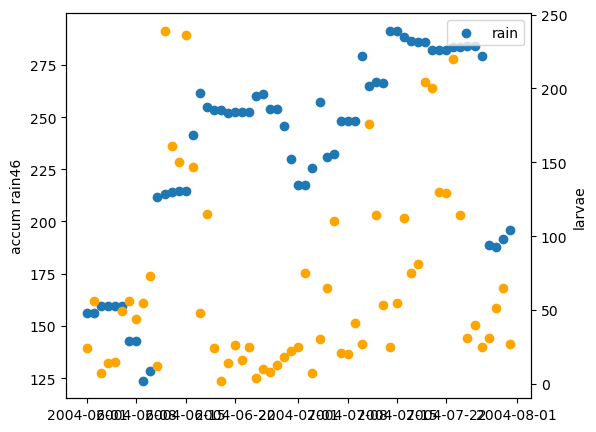

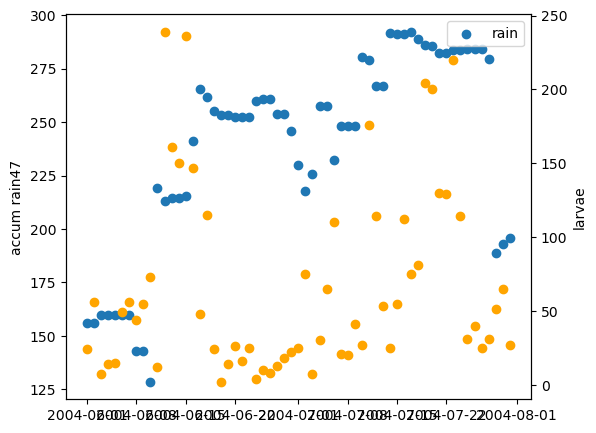

In [20]:
# jj = monthly(2004,fi)[1]
# plt.show()
s=0
for i in jj.columns[50:]:
    s=s+1
    fig, ax= plt.subplots(figsize=(6,5))
    ax.scatter(jj.index,jj[i])
    plt.legend(['rain'])
    ax.set_ylabel('accum rain'+str(s))
#     ax.set_xticks(jj.index,rotation=45)
    ax2 = ax.twinx()
    ax2.scatter(jj.index,jj['lar'],color='orange')
    ax2.set_ylabel('larvae')
#     plt.show()

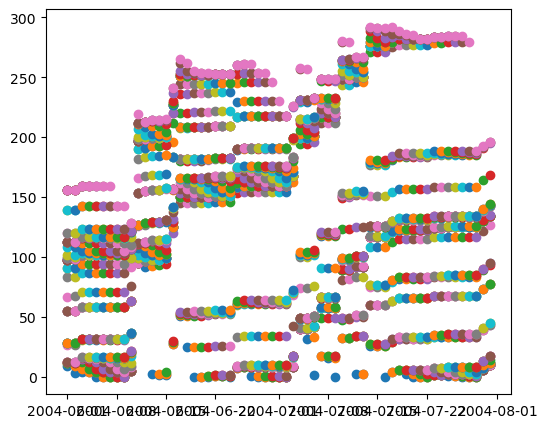

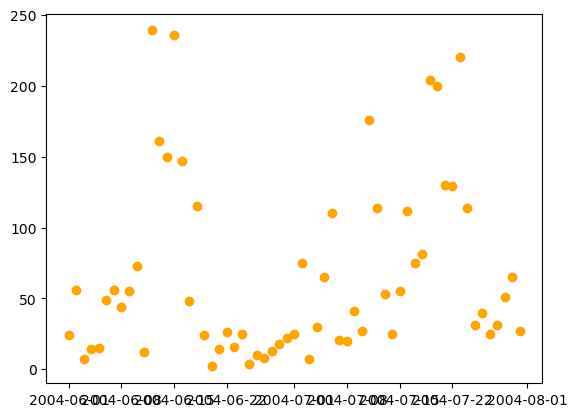

In [11]:
fig, ax= plt.subplots(figsize=(6,5))
for i in jj.columns[50:]:
    ax.scatter(jj.index,jj[i])
plt.show()
plt.scatter(jj.index,jj['lar'],color='orange')

(0.0, 5.0)

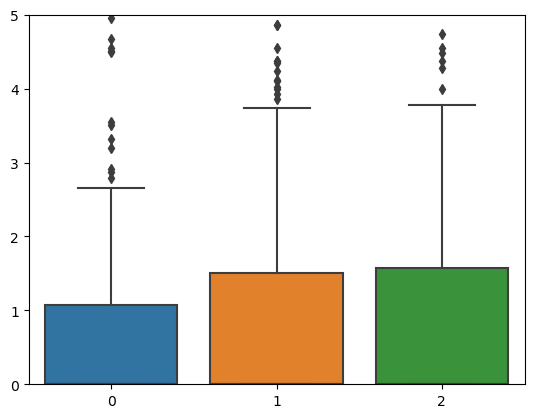

In [22]:
## Rainfall trend in bucket data collection period
# for i in range(2003,2006):
sns.boxplot([champbuck.groupby('time.year')[i] for i in range(2003,2006)])
plt.ylim(0,5)

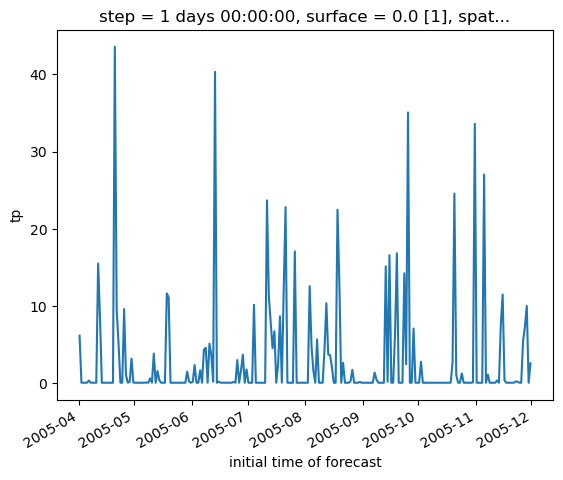

In [41]:
# xr.open_dataset(fi[1]).sel(x=slice(734,737),y=slice(488,490)).mean(('x','y'))['tp'].plot()
c = champbuck.groupby('time.year')[2005]
c[c.time.dt.month.isin(range(4,12))].plot()

In [ ]:
# def locwise(year): """ No info about locations to run this function"""
#     bucket=buckdata(year)
#     s=-1
#     for i in bucket.columns:
#         s=s+1
#         bucket['junjul'] = bucket[bucket.index.month.isin([6,7])][i]
#         bucket['augsep'] = bucket[bucket.index.month.isin([8,9])][i]
#         junjul = bucket[bucket.index.month.isin([6,7])][['junjul']]
#         augsep = bucket[bucket.index.month.isin([8,9])][['augsep']]
#         sav = champcity.sel(x=buckgpd.iloc[s]['Lon'],y=buckgpd.iloc[s]['Lat'],method='nearest')
#         sav = sav.groupby('time.year')[2003]
#         for i in range(1,50):
#             delt = junjul.index-timedelta(i)
#             delt1 = augsep.index-timedelta(i)
#             junjul['lag-'+str(i)]=sav[sav.time.dt.date.isin(delt.date)].values
#             try:
#                 augsep['lag-'+str(i)]=list(sav[sav.time.dt.date.isin(delt1.date)].values)
#             except:
#                 augsep['lag-'+str(i)]=list(sav[sav.time.dt.date.isin(delt1.date)].values)+[0]
#         for i in range(2,len(junjul.columns)-1):
#             junjul['accum-'+str(i)] = junjul[junjul.columns[1:i+1]].sum(axis=1)
#             augsep['accum-'+str(i)] = augsep[augsep.columns[1:i+1]].sum(axis=1)
#         from matplotlib.pyplot import figure
#         fig, (ax1,ax2) = plt.subplots(1,2,figsize=(22,22))
#         sns.heatmap(junjul.corr()[['junjul']],annot=True,ax=ax1)
#         sns.heatmap(augsep.corr()[['augsep']],annot=True,ax=ax2)
#         plt.show()